# Exercise 5: Sinusoidal model

In this exercise you will experiment with the sinusoidal model, measuring and tracking sinusoids in different kinds of audio signals. You will use the sinusoidal model to analyze short synthetic sounds with the goal to better understand various aspects of sinusoid estimation and tracking. You will experiment with different parameters and enhancements of the sinusoidal modeling approach.

There are four parts in this exercise: 1) Minimizing the frequency estimation error of a sinusoid, 2) Tracking a two component chirp, 3) Tracking sinusoids of different amplitudes, and 4) Sinusoidal modeling of a multicomponent signal.

### Relevant Concepts

__Chirp signals:__
A chirp is a signal whose frequency varies with time. In an up-chirp, the frequency increases in time. In Part 2 of the exercise, we will use a synthetically generated linear chirp with two frequency components. The frequency components are very close to each other and to resolve the two components, you need to use a large window. However, the frequency of a chirp continuously changes, which implies that we need a shorter window for analysis to capture this continuously changing frequency. Hence, there exists a tradeoff between the best set of sinusoidal analysis parameters to achieve a good tracking of the two components of the chirp.

__Sinusoidal modeling and sine tracking:__
Sinusoidal modeling aims to model each frame of audio with a set of sinusoids, from which we can reconstruct the input audio with minimum reconstruction error. The basic peak detection task performed in the spectrum of a frame can be enhanced in many ways to obtain the most compact representation possible and the most meaningful one for a particular task. One of the enhancements implemented in sms-tools is the tracking of the estimated sinusoids over time. In sounds with stable notes, the sinusoids tend to last over several frames and this can be used to discard spurious sinusoids that have been estimated. There are two functions in `sineModel.py` that together perform sine tracking. The function `sineTracking()` tracks peaks from one frame to the next, to give tracks of the sinusoids in time. The function `cleaningSineTracks()` then cleans up the tracks by discarding short spurious sinusoids based on a length threshold. These functions use the following parameters to do sine tracking.

1. `maxnSines`: Maximum number of sines tracked per frame.
2. `minSineDur`: Minimum duration of a sinusoidal track in seconds.
3. `freqDevOffset`: The minimum frequency deviation at 0Hz. Since the frequency of sinusoidal tracks can change slowly over time, it is necessary to have a margin of allowed deviation to track the change over time.
4. `freqDevSlope`: Slope increase of minimum frequency deviation. The common deviations are  more pronounced at higher frequency and we compensate for that using a scaling factor, which provides a higher deviation allowance at higher frequencies.

If we set `minSineDur = 0`, it retains all the spectral peaks detected. `maxnSines` can be set according to our prior knowledge about the number of sinusoids present in the signal. `freqDevOffset` intuitively can be set to be the minimum distance between two consecutive sinusoids (or harmonics in the case of harmonic sounds).

__Tracking low amplitude sinusoids:__
Tracking sinusoids of low amplitude among other sinusoids of high amplitude presents several challenges. In a signal that has two sinusoidal components with a very large difference in their amplitude, the analysis window we use is critical. If we use a window that has high sidelobe levels, the mainlobe of the sinusoid with low amplitude might get buried under the sidelobes of the dominant high amplitude sinusoid. When the amplitude difference is huge you need to choose a window that will ensure that the sidelobe levels of the louder sinusoid is lower than the mainlobe level of the softer sinusoid.

## Part 1 - Minimizing the frequency estimation error of a sinusoid

The function `min_freq_est_err()` should estimate the frequency of a sinusoidal signal at a given time instant. The function should return the estimated frequency in Hz, together with the window size and the FFT size used in the analysis.  

The input arguments to the function are the wav file name including the path (`input_file`) containing the sinusoidal signal, and the frequency of the sinusoid in Hz (`f`). The frequency of the input sinusoid can range between 100Hz and 2000Hz. The function should return a three element tuple of the estimated frequency of the sinusoid (`f_est`), the window size (`M`), and the FFT size (`N`) used.

The input wav file should be a stationary audio signal consisting of a single sinusoid of length >=1 second. Since the signal is stationary you can just perform the analysis of a single frame, for example in the middle of the sound file (time equal to .5 seconds). The analysis process would be to first select a fragment of the signal equal to the window size, `M`, centered at .5 seconds, then compute the DFT using the `dftAnal()` function, and finally use the `peakDetection()` and `peakInterp()` functions to obtain the frequency value of the sinusoid.

Use a Blackman window for analysis and a magnitude threshold `t = -40`dB for peak picking. The window size and FFT size should be chosen such that the difference between the true frequency (`f`) and the estimated frequency (`fEst`) is less than 0.05 Hz for the entire allowed frequency range of the input sinusoid. The window size should be the minimum positive integer of the form `100*k + 1` (where `k` is a positive integer) for which the frequency estimation error is < 0.05Hz. For a window size `M`, take the FFT size (`N`) to be the smallest power of 2 larger than `M`.

HINT: Computing `M` theoritically using a formula might be complex in such cases. Instead, you need to follow a heuristic approach to determine the optimal value of `M` and `N` for a particular `f`. You can iterate over all allowed values of window size `M` and stop when the condition is satisfied (i.e. the frequency estimation error < 0.05 Hz).

In [4]:
import numpy as np
from scipy.signal import get_window
import math
from smstools.models import dftModel as DFT
from smstools.models import utilFunctions as UF
from smstools.models import stft
from smstools.models import sineModel as SM
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# E5 - 1.1: Complete the function min_freq_est_err()

def compute_freq_estimate(input_file, f, window, t, M, N):
    """Compute the frequency estimate of a sinusoid in an audio signal.

    Args:
            input_file (str): wav file
            f (float): frequency of the sinusoid present in the input audio signal (Hz)
            window (str): analysis window type
            t (float): threshold in dB for peak detection
            M (int): Window size
            N (int): FFT size

    Result:
            f_est (float): estimated frequency of the sinusoid (Hz)
        """
    # read input audio file
    fs, x = UF.wavread(input_file)

    # The analysis process would be to first select a fragment of the signal equal to the window size, `M`, centered at .5 seconds
    center = 0.5 * fs
    M = int(M)  # Make sure M is an integer if it's not already
    start = int(center - M // 2)
    end = int(start + M)
    x = x[start:end]

    
    # compute STFT
    w = get_window(window, M)
    mX, pX = DFT.dftAnal(x, w, N)

    # detect peaks
    pks = UF.peakDetection(mX, t)

    # print(f"Detected peaks at indices: {pks}")

    # interpolate peak location, magnitude, and phase
    iploc, ipmag, ipphase = UF.peakInterp(mX, pX, pks)

    # print(f"Interpolated peak locations: {iploc}")

    # compute the estimated frequency from interpolated peak location
    f_est = fs * iploc[0] / N

    # print(f"Estimated frequency: {f_est}")
    
    # return the estimated frequency
    return f_est



def min_freq_est_err(input_file, f):
    """Best estimate the frequency of a sinusoid by iterating over different sizes of analysis window.

    Args:
            input_file (str): wav file
            f (float): frequency of the sinusoid present in the input audio signal (Hz)

    Result:
            f_est (float): estimated frequency of the sinusoid (Hz)
            M (int): Window size
            N (int): FFT size

    """
    # analysis parameters:
    window = 'blackman'
    t = -40
    min_err = 0.05

    # possible window and FFT sizes
    K = 20
    M, N = [100*k + 1 for k in range(1, K)], [2**(int((100*k + 1).bit_length())) for k in range(1, K)]
    # print("These are the possible M values:", M)
    # print("These are the possible N values:", N)
    
    # initialize best parameters
    best_params = (0, 0, 0)
    
    # iterate over all combinations of M and N
    for k in range(len(M)):
        m = M[k]
        n = N[k]
        # compute the frequency estimate
        f_est = compute_freq_estimate(input_file, f, window, t, m, n)
        # compute the error
        err = abs(f_est - f)

        print(f"Trying M={m}, N={n}: Estimated frequency = {f_est}, Error = {err}")
        # update the minimum error and corresponding parameters
        if err < min_err:
            min_err = err
            best_params = (f_est, m, n)
            print(f"New best parameters found: {best_params}")

    return best_params


Test cases for `min_freq_est_err()`:

__Test case 1:__ If you run your code with `input_file = '../sounds/sine-490.wav'`, `f = 490.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 489.963` and the frequency estimation error is 0.037.

__Test case 2:__ If you run your code with `input_file = '../sounds/sine-1000.wav'`, `f = 1000.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 1000.02` and the frequency estimation error is 0.02.

__Test case 3:__ If you run your code with `input_file = '../sounds/sine-200.wav'`, `f = 200.0 Hz`, the optimal
values are `M = 1201`, `N = 2048`, `f_est = 200.038` and the frequency estimation error is 0.038.

Interesting validation is to check if these frequency estimation errors are perceptually relevant. To do that you can generate and listen the estimated frequencies, by generating a sinusoid with that frequency, and check if you perceive a difference with the original sinusoid.

In [4]:
# E5 - 1.2: 
# For each of the 3 test cases, play the input sinusoid, call the function min_freq_est_err(),
# generate sinusoid with estimated frequency value, and play it. Explain the result.


print(f"__Test case 1:__")

input_file = '../sounds/sine-490.wav'
f = 490.0

# play input sinusoid
UF.wavplay(input_file)

# call the function min_freq_est_err()
f_est, M, N = min_freq_est_err(input_file, f)

print(f"Estimated frequency: {f_est} Hz with M={M} and N={N}")

# generate sinusoid with estimated frequency value
fs = 44100  # assuming a standard sampling rate
duration = 1.0  # assuming a duration of 1 second
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
estimated_sinusoid = 0.5 * np.sin(2 * np.pi * f_est * t)

# play the estimated sinusoid
ipd.display(ipd.Audio(estimated_sinusoid, rate=fs))


__Test case 1:__
Trying M=101, N=128: Estimated frequency = 552.7592438300801, Error = 62.759243830080095
Trying M=201, N=256: Estimated frequency = 489.6651121410587, Error = 0.33488785894127204
Trying M=301, N=512: Estimated frequency = 489.74152368005576, Error = 0.25847631994423637
Trying M=401, N=512: Estimated frequency = 489.6329508555221, Error = 0.36704914447790316
Trying M=501, N=512: Estimated frequency = 489.44768390227614, Error = 0.5523160977238604
Trying M=601, N=1024: Estimated frequency = 490.07388678286594, Error = 0.07388678286594086
Trying M=701, N=1024: Estimated frequency = 490.108355179418, Error = 0.10835517941802664
Trying M=801, N=1024: Estimated frequency = 490.143665806852, Error = 0.14366580685202734
Trying M=901, N=1024: Estimated frequency = 490.1833922084902, Error = 0.1833922084902042
Trying M=1001, N=1024: Estimated frequency = 490.2295648102081, Error = 0.22956481020810315
Trying M=1101, N=2048: Estimated frequency = 489.9630183009079, Error = 0.03698

In [5]:
print(f"__Test case 2:__")
input_file = '../sounds/sine-1000.wav'
f = 1000.0

# play input sinusoid
UF.wavplay(input_file)

# call the function min_freq_est_err()
f_est, M, N = min_freq_est_err(input_file, f)

print(f"Estimated frequency: {f_est} Hz with M={M} and N={N}")

# generate sinusoid with estimated frequency value
fs = 44100  # assuming a standard sampling rate
duration = 1.0  # assuming a duration of 1 second
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
estimated_sinusoid = 0.5 * np.sin(2 * np.pi * f_est * t)

# play the estimated sinusoid
ipd.display(ipd.Audio(estimated_sinusoid, rate=fs))

__Test case 2:__
Trying M=101, N=128: Estimated frequency = 999.4266656359954, Error = 0.5733343640046087
Trying M=201, N=256: Estimated frequency = 999.3601328732271, Error = 0.639867126772856
Trying M=301, N=512: Estimated frequency = 999.8618204186016, Error = 0.13817958139838993
Trying M=401, N=512: Estimated frequency = 999.7372665297117, Error = 0.26273347028825356
Trying M=501, N=512: Estimated frequency = 999.5665525831362, Error = 0.43344741686382804
Trying M=601, N=1024: Estimated frequency = 1000.0841576732756, Error = 0.08415767327562662
Trying M=701, N=1024: Estimated frequency = 1000.1172027679742, Error = 0.11720276797416318
Trying M=801, N=1024: Estimated frequency = 1000.1548163108826, Error = 0.154816310882552
Trying M=901, N=1024: Estimated frequency = 1000.1989950485238, Error = 0.19899504852378413
Trying M=1001, N=1024: Estimated frequency = 1000.2505107906064, Error = 0.2505107906064268
Trying M=1101, N=2048: Estimated frequency = 1000.0199426829796, Error = 0.019

In [6]:
print(f"__Test case 3:__")
input_file = '../sounds/sine-200.wav'
f = 200.0

# play input sinusoid
UF.wavplay(input_file)

# call the function min_freq_est_err()
f_est, M, N = min_freq_est_err(input_file, f)

print(f"Estimated frequency: {f_est} Hz with M={M} and N={N}")

# generate sinusoid with estimated frequency value
fs = 44100  # assuming a standard sampling rate
duration = 1.0  # assuming a duration of 1 second
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
estimated_sinusoid = 0.5 * np.sin(2 * np.pi * f_est * t)

# play the estimated sinusoid
ipd.display(ipd.Audio(estimated_sinusoid, rate=fs))

__Test case 3:__
Trying M=101, N=128: Estimated frequency = 499.35891578317813, Error = 299.35891578317813
Trying M=201, N=256: Estimated frequency = 258.0991676424806, Error = 58.09916764248061
Trying M=301, N=512: Estimated frequency = 206.43354986861036, Error = 6.433549868610356
Trying M=401, N=512: Estimated frequency = 200.8236706975525, Error = 0.823670697552501
Trying M=501, N=512: Estimated frequency = 200.46809153402214, Error = 0.4680915340221361
Trying M=601, N=1024: Estimated frequency = 199.8960145345785, Error = 0.10398546542148779
Trying M=701, N=1024: Estimated frequency = 199.9177289331982, Error = 0.08227106680180896
Trying M=801, N=1024: Estimated frequency = 199.81769570509636, Error = 0.18230429490364486
Trying M=901, N=1024: Estimated frequency = 199.8233550417679, Error = 0.1766449582320888
Trying M=1001, N=1024: Estimated frequency = 199.7393084362401, Error = 0.2606915637599059
Trying M=1101, N=2048: Estimated frequency = 200.05055070209755, Error = 0.05055070

**Question  E5 - 1.2:**

#### Explain the results of  1.1
------

The resulting sounds from the estimated sinusoids seems equal to the original sounds. If there are differences, they are so small that can't be detected.

## Part 2 - Tracking a two component chirp

In this part you should perform the best possible sinusoidal analysis of a two component chirp signal by focusing on the window-size, `M`, of the function `sineModelAnal()`.

You should use the sound `chirp-150-190-linear.wav`, which is a linear chirp with two sinusoids with starting frequencies of 150Hz and 190Hz, and finishing at 1400Hz and 1440Hz after 2 seconds. The estimation and tracking of the two varying frequencies should result in a mean error smaller than 2Hz.

Several functions are already defined to do this part of the exercise. Read them and understand what they do. The function `freq_tracker_error()` performs a sinusoidal analysis using the `sineModelAnal()` function, then compares the analysis results, `fTrackEst`, with the ideal frequency values, given as input, and returns the mean error `meanErr`.

Get familiar with the signal by listening to the sound and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram.

In [7]:
# functions used in exercises of Part 2 and 3

def gen_time_stamps(xlen, M, fs, H):
    """Generate frame time stamps for a given signal length and sampling rate.

    Args:
        xlen (int): duration of signal in samples
        M (int): window size
        fs (int): sampling rate
        H (int): hop size

    Result:
        np.array: time stamps

    """
    hM1 = int(np.floor((M+1)/2))
    hM2 = int(np.floor(M/2))
    xlen = xlen + 2*hM2
    pin = hM1
    pend = xlen - hM1
    tStamps = np.arange(pin,pend,H)/float(fs)
    return tStamps

def gen_true_freq_tracks_chirp_150_190(tStamps):
    """Generate the frequency values present in file "../sounds/chirp-150-190-linear.wav"

    Args:
        tStamps (np.array): time stamps

    Result:
        np.array: time stamps and frequency values of predefined chirp

    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(np.linspace(190, 190+1250, len(tStamps)))
    fTrack[:,1] = np.transpose(np.linspace(150, 150+1250, len(tStamps)))
    return fTrack

def gen_true_freq_tracks_440_602(tStamps):
    """Generate the frequency values present in file "../sounds/sines-440-602-hRange.wav"

    Args:
        tStamps (np.array): time stamps

    Result:
        np.array: time stamps and frequency values of predefined chirp

    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(440*np.ones((len(tStamps),1)))
    fTrack[:,1] = np.transpose(602*np.ones((len(tStamps),1)))
    return fTrack

def freq_tracker_error(input_file, fTrackTrue, window, t, H, M):
    """Estimate sinusoidal values of a sound

    Args:
        input_file (str): wav file including the path
        fTrackTrue (np.array): array of true frequency values, one row per time frame, one column per component
        window (str): window type used for analysis
        t (float): peak picking threshold (negative dB)
        H (int): hop size in samples
        M (int): window size in samples

   Result:
           float: mean estimation error
           np.array: estimated frequency values, one row per time frame, one column per component

    """

    N = int(pow(2, np.ceil(np.log2(M))))        # FFT Size, power of 2 larger than M
    maxnSines = 2                               # Maximum number of sinusoids at any time frame
    minSineDur = 0.0                            # minimum duration set to zero to not do tracking
    freqDevOffset = 30                          # minimum frequency deviation at 0Hz
    freqDevSlope = 0.001                        # slope increase of minimum frequency deviation

    fs, x = UF.wavread(input_file)              # read input sound
    w = get_window(window, M)                   # Compute analysis window
    # analyze the sound with the sinusoidal model
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    tailF = 20
    # Compute mean estimation error. 20 frames at the beginning and end not used to compute error
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)

    return (meanErr, fTrackEst)

The most important input parameter of the function `freq_tracker_error()` in order to obtain the best possible results, that is, minimum error, is the window-size, `M`.

Ideally `M` should be chosen to obtain a mean estimation error (`meanErr`) of each frequency component less than 2Hz. There is a range of values of `M` for which this is true and all of those values would be good. Plotting the estimated and true frequency tracks shouldd be done to visualize the accuracy of estimation.

The function `gen_time_stamps()` generates the time stamps as needed for comparing the true and the estimated frequency values. The function `gen_true_freq_tracks_150_190()` generates the true frequency values of `chirp-150-190-linear.wav`, so that we can compare the true and the estimated frequency values.

NOTE: Do not do just trial and error. Understand the problem and calculate the `M` that should work best. Then test it and refine the answer using the code.

__Test case:__ Choosing `M = 1023`, the mean estimation error should be `[13.669, 528.533]` Hz, which as you can see do not give us the desired estimation errors.

Initial mean frequency estimation error: [ 13.66932655 528.5333854 ]


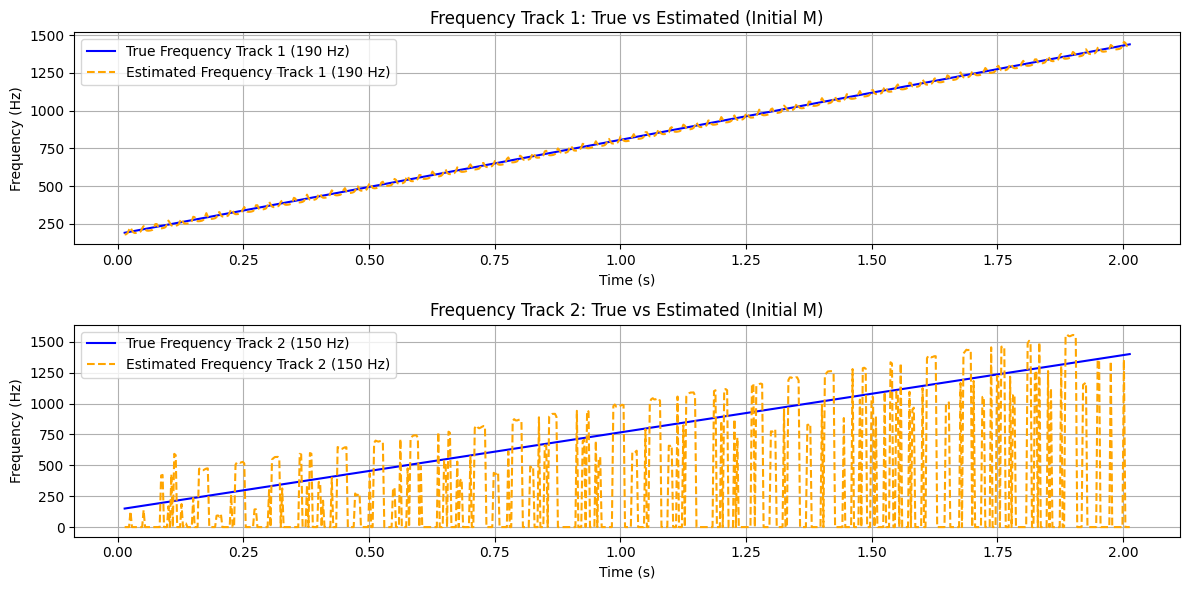

In [ ]:
# E5 - 2.1: 
# First call function freq_tracker_error() with the test case values and plot the true versus the
# estimated frequency values, then change the window-size to obtain minimum possible error, and plot the new
# estimated frequency values. Explain the choice and result.

H = 128
window = 'blackman'
t = -80
input_file = '../sounds/chirp-150-190-linear.wav'
fs, x = UF.wavread(input_file)
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_chirp_150_190(tStamps)

# Initial window size
M = 1023
meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)
print(f"Initial mean frequency estimation error: {meanErr}")

# Plot true vs estimated frequency values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(tStamps, fTrackTrue[:, 0], label='True Frequency Track 1 (190 Hz)', color='blue')
plt.plot(tStamps, fTrackEst[:, 0], label='Estimated Frequency Track 1 (190 Hz)', color='orange', linestyle='--')
plt.title('Frequency Track 1: True vs Estimated (Initial M)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(tStamps, fTrackTrue[:, 1], label='True Frequency Track 2 (150 Hz)', color='blue')
plt.plot(tStamps, fTrackEst[:, 1], label='Estimated Frequency Track 2 (150 Hz)', color='orange', linestyle='--')
plt.title('Frequency Track 2: True vs Estimated (Initial M)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Optimal minimal window size M for better frequency resolution: 6615
Mean frequency estimation error with M_optimal=6615: [10.20918393 28.3468712 ]


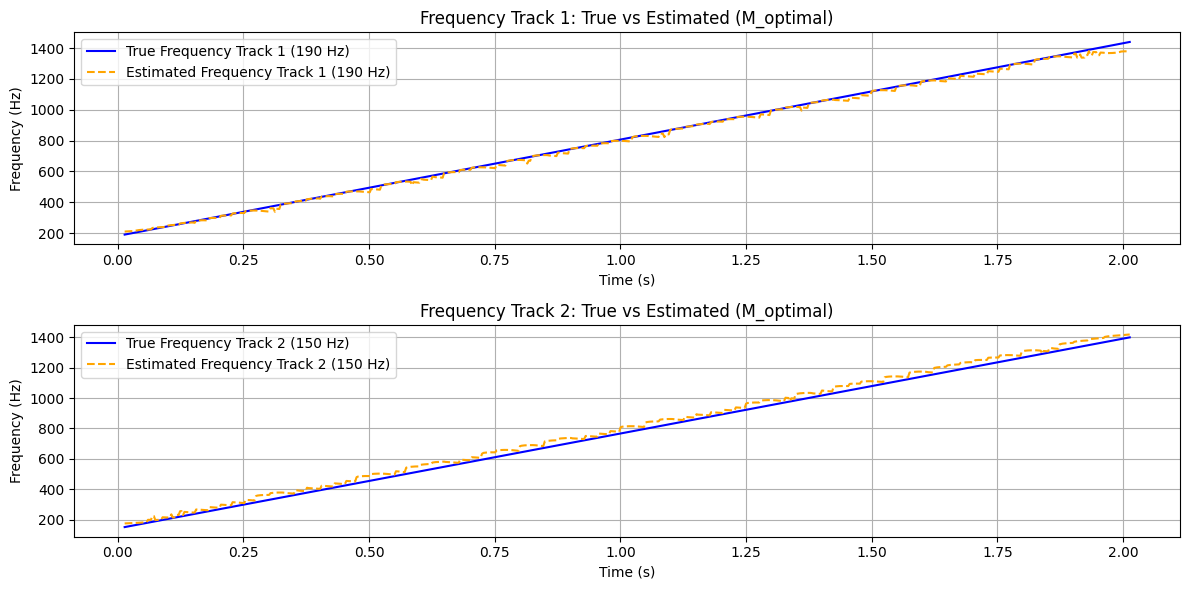

In [ ]:
# Compute optimal M for two sinusoid components:
# M >= B_s * f_s / |f_{k+1} - f_k|
# where B_s is the main lobe width of the Blackman window (~6)

B_s = 6 # Main lobe width for Blackman window
delta_f = 40  # Minimum frequency separation between the two sinusoids (190 - 150)
M_optimal = int(np.ceil(B_s * fs / delta_f))

print(f"Optimal minimal window size M for better frequency resolution: {M_optimal}")

# Compute frequency estimation error for M_optimal
meanErr_optimal, fTrackEst_optimal = freq_tracker_error(input_file, fTrackTrue, window, t, H, M_optimal)
print(f"Mean frequency estimation error with M_optimal={M_optimal}: {meanErr_optimal}")

# Plot true vs estimated frequency values with M_optimal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(tStamps, fTrackTrue[:, 0], label='True Frequency Track 1 (190 Hz)', color='blue')
plt.plot(tStamps, fTrackEst_optimal[:, 0], label='Estimated Frequency Track 1 (190 Hz)', color='orange', linestyle='--')
plt.title('Frequency Track 1: True vs Estimated (M_optimal)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(tStamps, fTrackTrue[:, 1], label='True Frequency Track 2 (150 Hz)', color='blue')
plt.plot(tStamps, fTrackEst_optimal[:, 1], label='Estimated Frequency Track 2 (150 Hz)', color='orange', linestyle='--')
plt.title('Frequency Track 2: True vs Estimated (M_optimal)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Trying M=6815: Mean frequency estimation error: [ 9.81300323 28.78885775]
Trying M=7015: Mean frequency estimation error: [10.79927679 29.43062493]
Trying M=7215: Mean frequency estimation error: [11.6739807  30.96918287]
Trying M=7415: Mean frequency estimation error: [ 9.37764113 28.15838251]
Trying M=7615: Mean frequency estimation error: [11.73910314 26.78968417]
Trying M=7815: Mean frequency estimation error: [14.71143476 26.81214873]
Trying M=8015: Mean frequency estimation error: [13.77523965 23.02387776]
Trying M=8215: Mean frequency estimation error: [ 9.00828676 15.38004541]
Trying M=8415: Mean frequency estimation error: [25.48555353 30.28826955]
Trying M=8615: Mean frequency estimation error: [26.20053342 29.69177979]
Trying M=8815: Mean frequency estimation error: [11.20863539 13.10768317]
Trying M=9015: Mean frequency estimation error: [27.38056442 28.37930707]
Trying M=9215: Mean frequency estimation error: [27.65075441 28.03574972]
Trying M=9415: Mean frequency estimati

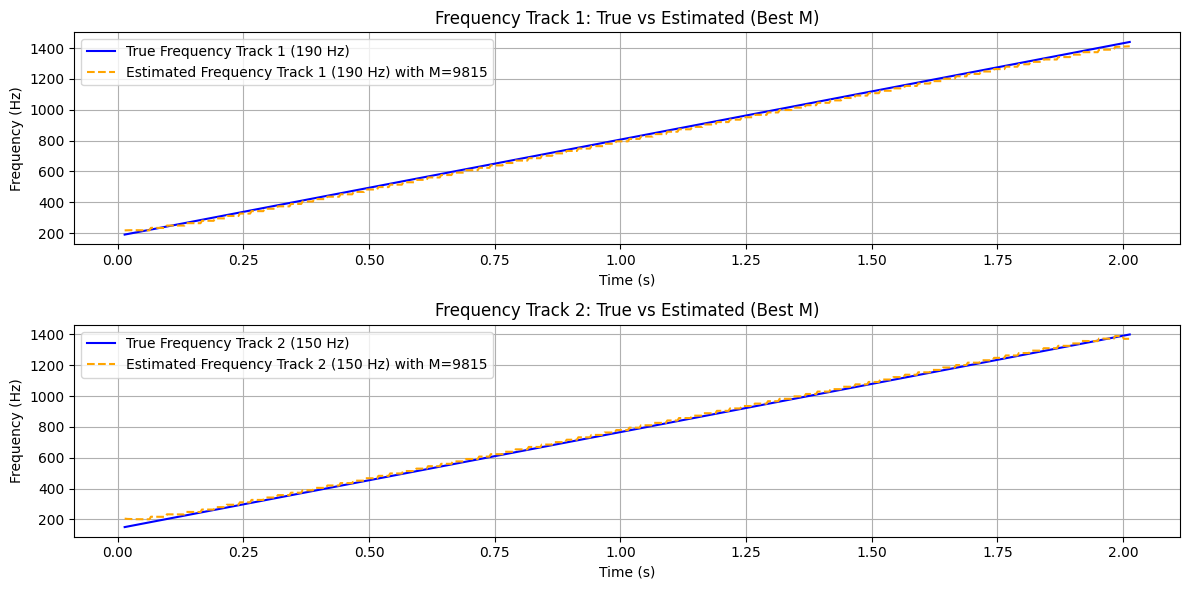

In [10]:
# Since window size should be greater than or equal to M_optimal, other than M_optimal, 
# we can try odd numbers greater than M_optimal

M_values = [M_optimal + 200 * i for i in range(1, 100)]  # Generate a list of odd M values
best_meanErr = meanErr_optimal
best_fTrackEst = fTrackEst_optimal
best_M = M_optimal

for m in M_values:
    meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, m)
    print(f"Trying M={m}: Mean frequency estimation error: {meanErr}")
    if np.mean(meanErr) < np.mean(best_meanErr):
        best_meanErr = meanErr
        best_fTrackEst = fTrackEst
        best_M = m

print(f"Best M found: {best_M} with mean frequency estimation error: {best_meanErr}")

# Plot true vs estimated frequency values with best M
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(tStamps, fTrackTrue[:, 0], label='True Frequency Track 1 (190 Hz)', color='blue')
plt.plot(tStamps, best_fTrackEst[:, 0], label=f'Estimated Frequency Track 1 (190 Hz) with M={best_M}', color='orange', linestyle='--')
plt.title('Frequency Track 1: True vs Estimated (Best M)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(tStamps, fTrackTrue[:, 1], label='True Frequency Track 2 (150 Hz)', color='blue')
plt.plot(tStamps, best_fTrackEst[:, 1], label=f'Estimated Frequency Track 2 (150 Hz) with M={best_M}', color='orange', linestyle='--')
plt.title('Frequency Track 2: True vs Estimated (Best M)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Trying M=6415: Mean frequency estimation error: [11.39184328 28.5259972 ]
Trying M=6215: Mean frequency estimation error: [12.55464655 26.40338628]
Trying M=6015: Mean frequency estimation error: [11.80870638 21.7926332 ]
Trying M=5815: Mean frequency estimation error: [1.64639755 7.00998641]
Trying M=5615: Mean frequency estimation error: [1.41307687 4.1838085 ]
Trying M=5415: Mean frequency estimation error: [1.22435697 2.90468374]
Trying M=5215: Mean frequency estimation error: [1.07254425 2.40850589]
Trying M=5015: Mean frequency estimation error: [0.94740871 1.89129445]
Trying M=4815: Mean frequency estimation error: [0.84327086 1.55707242]
Trying M=4615: Mean frequency estimation error: [0.76762641 1.39117034]
Trying M=4415: Mean frequency estimation error: [0.71798271 1.28865254]
Trying M=4215: Mean frequency estimation error: [0.68785435 1.2289667 ]
Trying M=4015: Mean frequency estimation error: [0.7243049 1.3181242]
Trying M=3815: Mean frequency estimation error: [0.75208573 

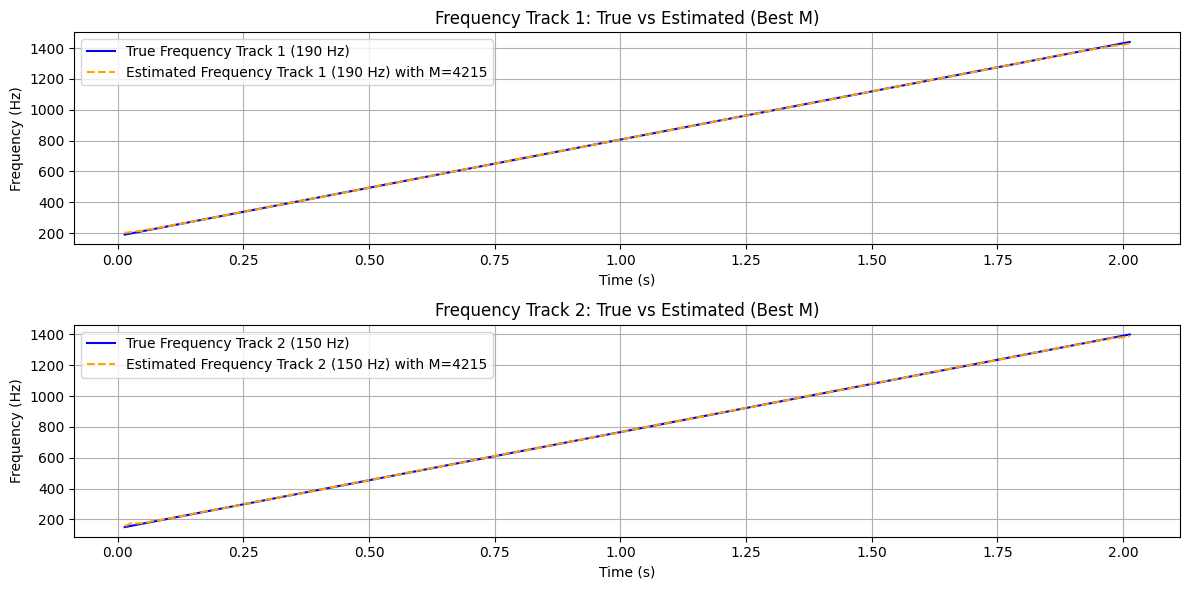

In [11]:
# Since window size should be greater than or equal to M_optimal, other than M_optimal, 
# we can try odd numbers greater than M_optimal

M_values = [M_optimal - 200 * i for i in range(1, 20)]  # Generate a list of odd M values
best_meanErr = meanErr_optimal
best_fTrackEst = fTrackEst_optimal
best_M = M_optimal

for m in M_values:
    meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, m)
    print(f"Trying M={m}: Mean frequency estimation error: {meanErr}")
    if np.mean(meanErr) < np.mean(best_meanErr):
        best_meanErr = meanErr
        best_fTrackEst = fTrackEst
        best_M = m

print(f"Best M found: {best_M} with mean frequency estimation error: {best_meanErr}")

# Plot true vs estimated frequency values with best M
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(tStamps, fTrackTrue[:, 0], label='True Frequency Track 1 (190 Hz)', color='blue')
plt.plot(tStamps, best_fTrackEst[:, 0], label=f'Estimated Frequency Track 1 (190 Hz) with M={best_M}', color='orange', linestyle='--')
plt.title('Frequency Track 1: True vs Estimated (Best M)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(tStamps, fTrackTrue[:, 1], label='True Frequency Track 2 (150 Hz)', color='blue')
plt.plot(tStamps, best_fTrackEst[:, 1], label=f'Estimated Frequency Track 2 (150 Hz) with M={best_M}', color='orange', linestyle='--')
plt.title('Frequency Track 2: True vs Estimated (Best M)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**Question  E5 - 2.2:**

#### Explain the results of  2.1
------

Frequency Resolution is given by $Δf= \frac{fs}{M}$, where fs is the sampling rate. This means a larger window size M gives better frequency separation. If M is too small, the sinusoids will blur together and be difficult to separate, especially when they are close to each other in frequency (like in the chirp we are analysing).

We’ll want M large enough to separate the two sinusoids effectively, but not so large that it averages out the frequency variations in the chirp.

This is captured by the condition:

  $$
  M \geq B_s \cdot \frac{f_s}{\Delta f}
  $$

  where $ B_s $ is the main-lobe bandwidth of the window, $ f_s $ is the sampling rate in Hz, and $ \Delta f $ is the frequency difference between the sinusoids.

Additionally, for a sinusoidal signal with frequencies $ f_k $ and $ f_{k+1} $, the window size should be large enough to capture their difference. This can be expressed as:

  $$
  M \geq B_s \cdot \frac{f_s}{\left| f_{k+1} - f_k \right|}
  $$

  This ensures that the window can capture the harmonics without blending them together.

  
Given the frequency range of the chirp (150 Hz to 1440 Hz) and assuming we want a good separation, if we start with an initial guess for M around 1023, we would have a frequency resolution of about:

$$Δ
𝑓
=
\frac{44100}
{1023}
≈
43 Hz$$

This resolution should be sufficient to separate frequencies in the range of 150 Hz to 1440 Hz, but if the two sinusoids start to merge, we might need to adjust M upwards to improve separation.

After running the test with the initial M, by evaluating the mean error and visualizing the tracking:

- If the error is due to poor frequency separation, we increase M.

- If the error is due to poor tracking of frequency changes, we decrease M to allow more frequent updates.

The M_optimal obtained with the formula described above is 6615, corresponding to a mean frequency estimation error of [10.20918393 28.3468712 ]
(better than the starting M=1023).

Then I tested odd values for M higher than the M_optimal, and I found out in Sonic Visualizer that there's a lost in time resolution. The reason why this happens is that the formula for the optimal window size M holds for two components that do not change in time.

In this case, we have an up-chirp, so we have to keep a trade-off between time and frequency resolutions.

That's why I started to try also window sizes smaller than M_optimal, and I found out that the best one is 4215 with mean frequency estimation error: [0.68785435 1.2289667 ].

## Part 3 -Tracking sinusoids of different amplitudes

In this part you should perform the best possible sinusoidal analysis of a signal with two sinusoidal components of different amplitudes by focusing on the type of window `window` and the magnitude threshold `t` of the function `sineModelAnal()`.

Use the input signal `sines-440-602-hRange.wav` which includes two sinusoidal components with a very large difference in their amplitude. It is a synthetically generated signal with frequency components 440Hz and 602Hz, `s = sin(2*pi*440*t) + 2e-3*sin(2*pi*602*t)`.

This part uses the same functions as Part 2.

Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. Notice the difference in the amplitudes of its components.

To do this exercise complete the next cell. Run the function `freq_tracker_error()` giving a value for the window type `window` and the  magnitude threshold `t`. Use the given values for the rest of parameters.

For the `sineModelAnal()` function we use a window length `M = 2047` samples, an FFT size `N = 4096` samples, and a hop size `H = 128` samples. For sine tracking, we set `minSineDur = 0.02` seconds, `freqDevOffset = 10`Hz, and `freqDevSlope = 0.001` (its default value). Since we need only two frequency component estimates at every frame, we set `maxnSines = 2`.

Set the input parameters `window` and `t` such that the mean estimation error of each frequency components is less than 2Hz. There is a range of values of `M` and `t` for which this is true and all of those values will be considered correct answers. You can plot the estimated and true frequency tracks to visualize the accuracy of estimation. The output is the set of parameters you used: `window`, `t`, the time stamps, estimated and the true frequency tracks. Note that choosing the wrong window might lead to tracking of one of the sidelobes of the high amplitude sinusoid instead of the mainlobe of the low amplitude sinusoid.

For the window, choose one of `'boxcar'`, `'hanning'`, `'hamming'`, `'blackman'`, or `'blackmanharris'`. `t` should be specified in negative dB.

NOTE: Do not do just trial and error. Understand the problem and calculate and `M` that should work. Then test it and refine the answer.

__Test case:__ Choosing `window = 'hanning'`, `t = -80.0`, the mean estimation error is `[0.19603701  29.51140815]` Hz.


Initial mean frequency estimation error: [ 0.19603701 29.51140584]


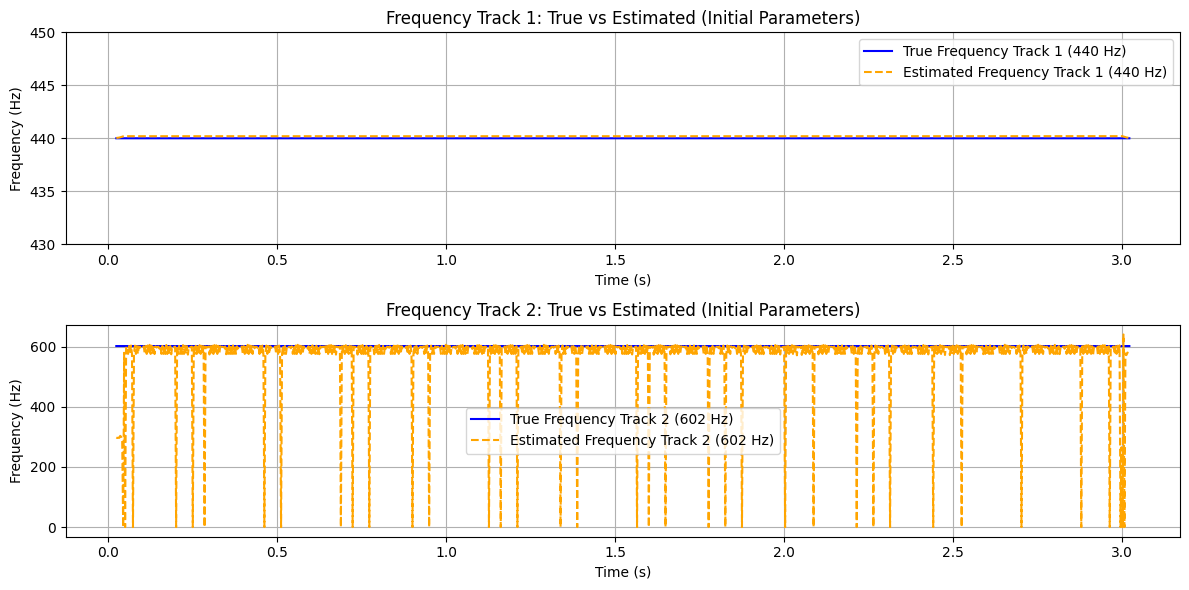

In [12]:
# E5 - 3.1: 
# First call freq_tracker_error() with the values for the test case and plot the true versus the
# estimated frequency values. Then choose the window and threshold to obtain minimum possible error, and plot
# the new estimated frequency values. Explain the result.

M = 2047                                             # Window size
N = 4096                                             # FFT Size
H = 128                                              # Hop size in samples
input_file = '../sounds/sines-440-602-hRange.wav'
fs, x = UF.wavread(input_file)
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_440_602 (tStamps)

window = 'hann'
t = -80
meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)
print(f"Initial mean frequency estimation error: {meanErr}")
# Plot true vs estimated frequency values
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(tStamps, fTrackTrue[:, 0], label='True Frequency Track 1 (440 Hz)', color='blue')
plt.plot(tStamps, fTrackEst[:, 0], label='Estimated Frequency Track 1 (440 Hz)', color='orange', linestyle='--')
plt.title('Frequency Track 1: True vs Estimated (Initial Parameters)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(430, 450)
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(tStamps, fTrackTrue[:, 1], label='True Frequency Track 2 (602 Hz)', color='blue')
plt.plot(tStamps, fTrackEst[:, 1], label='Estimated Frequency Track 2 (602 Hz)', color='orange', linestyle='--')
plt.title('Frequency Track 2: True vs Estimated (Initial Parameters)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid()    
plt.tight_layout()
plt.show()


**Try different window types and thresholds to minimize error**

#### I will try only Blackman and Blackman-Harris windows with thresholds -60, -80, -100 dB (see why in Explanation of results below) 

Window: blackman, Threshold: -60 dB → Mean frequency estimation error: [7.99435489e-02 3.62611745e+02]


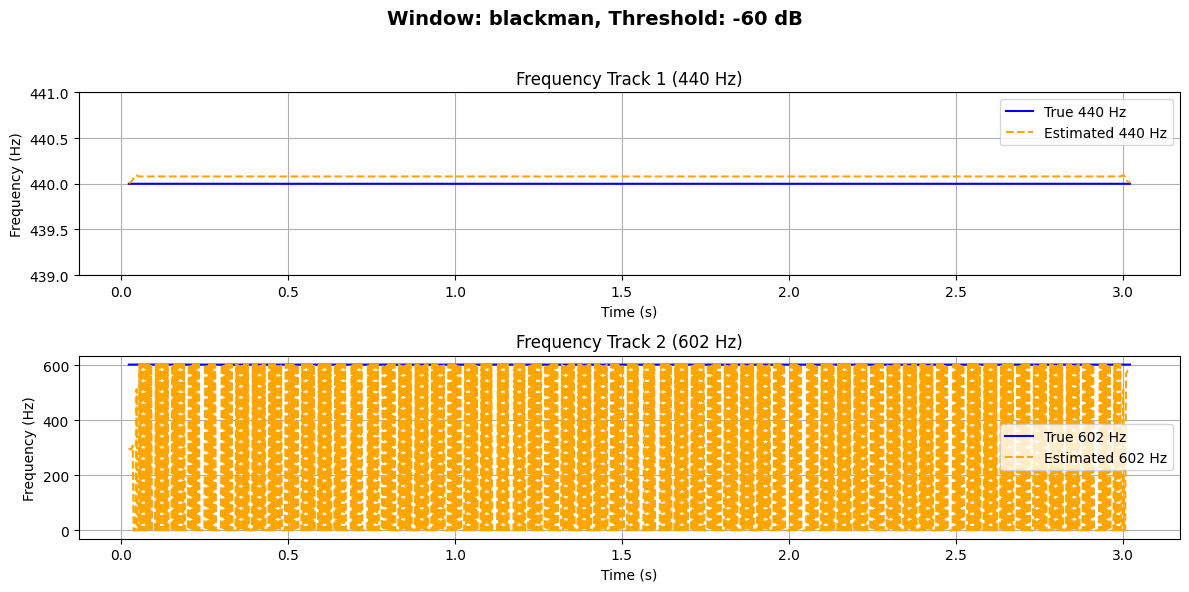

Window: blackman, Threshold: -80 dB → Mean frequency estimation error: [0.07994355 2.38233995]


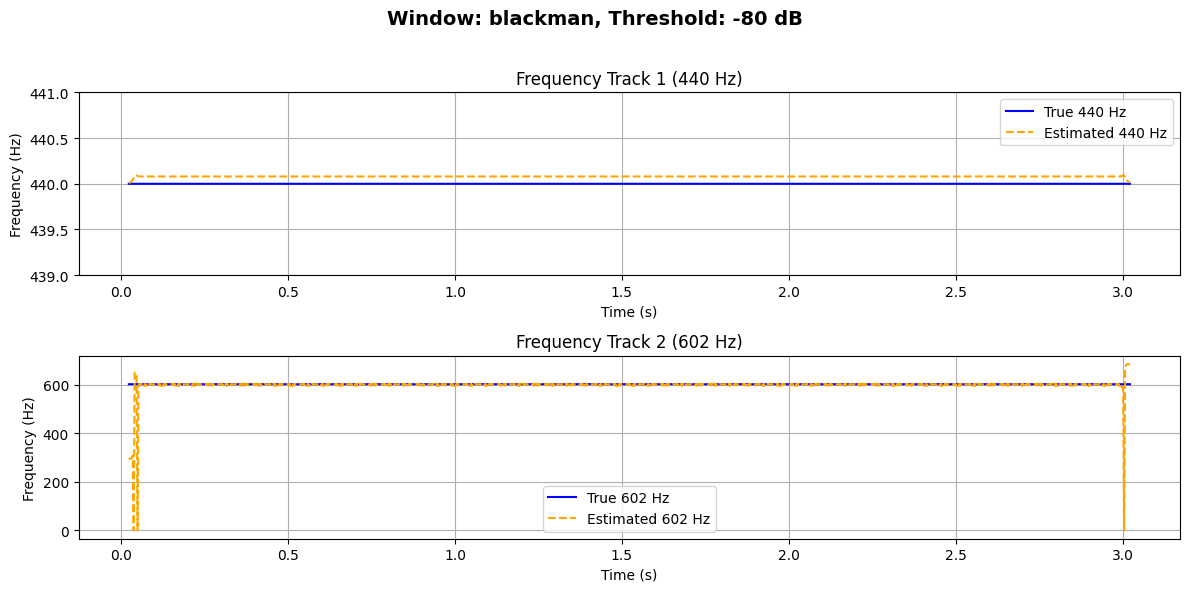

Window: blackman, Threshold: -100 dB → Mean frequency estimation error: [0.07994355 2.38233995]


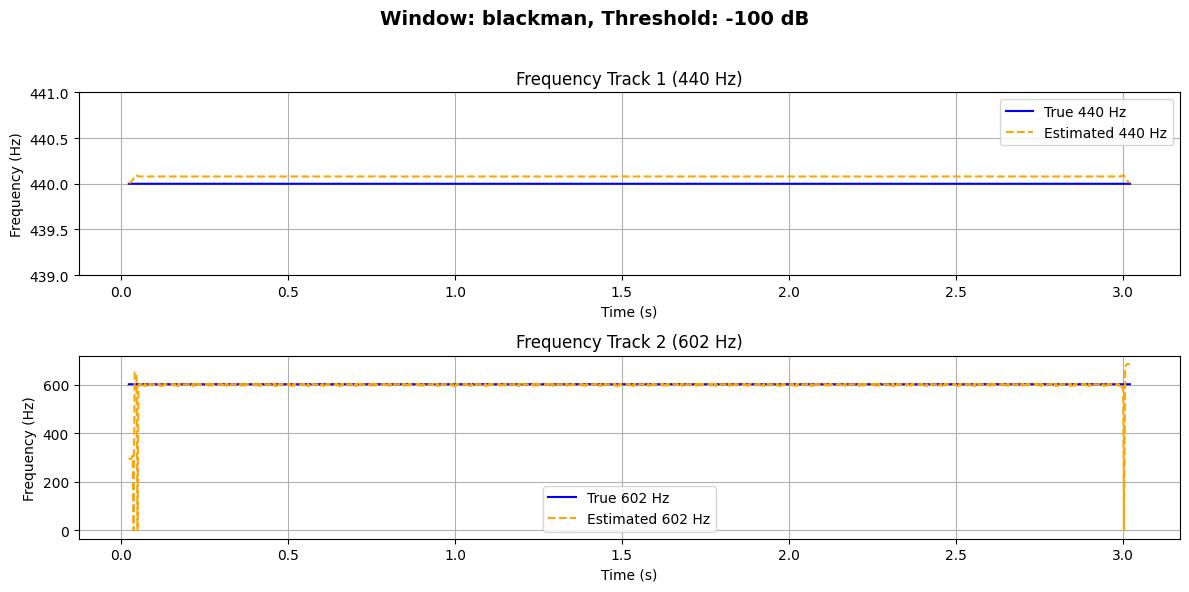

Window: blackmanharris, Threshold: -60 dB → Mean frequency estimation error: [3.84379361e-02 6.02000000e+02]


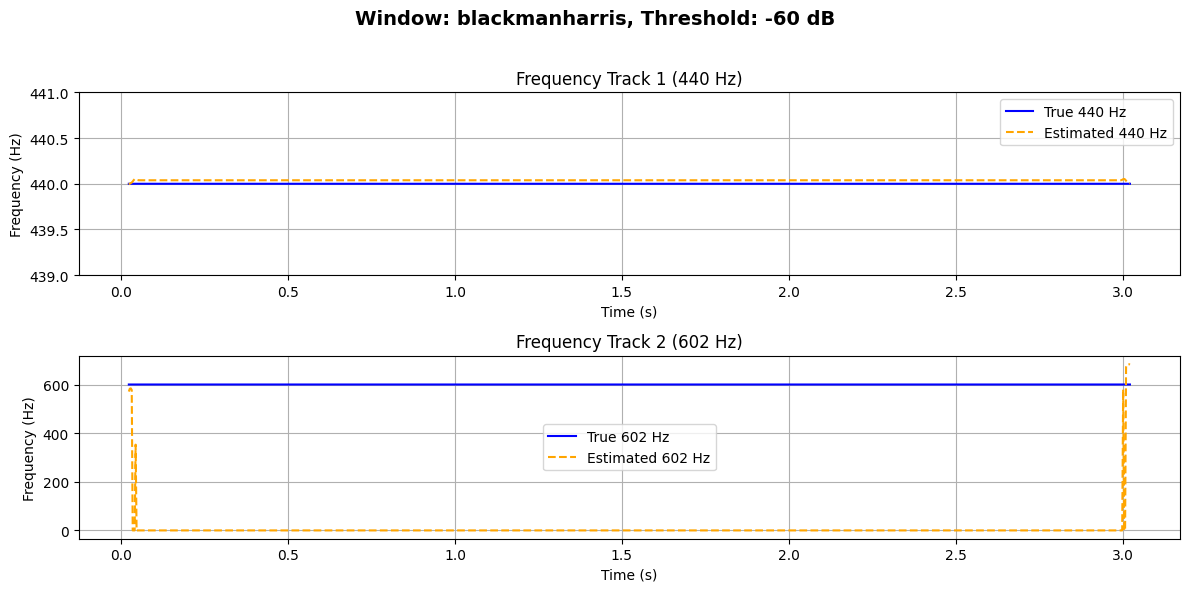

Window: blackmanharris, Threshold: -80 dB → Mean frequency estimation error: [0.03843794 0.06193919]


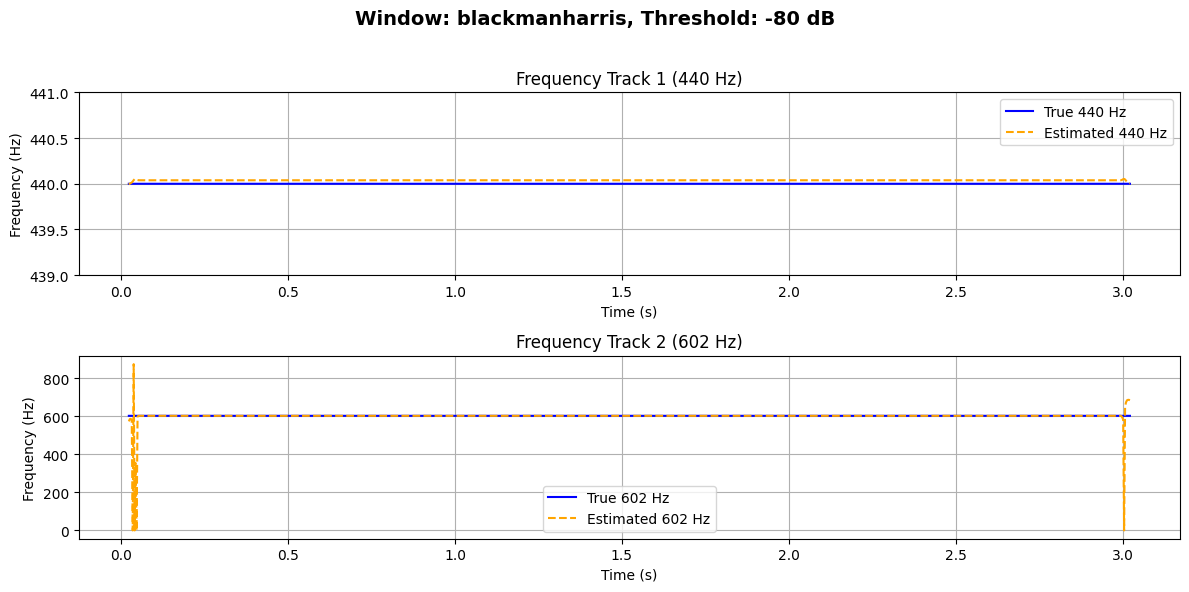

Window: blackmanharris, Threshold: -100 dB → Mean frequency estimation error: [0.03843794 0.06193919]


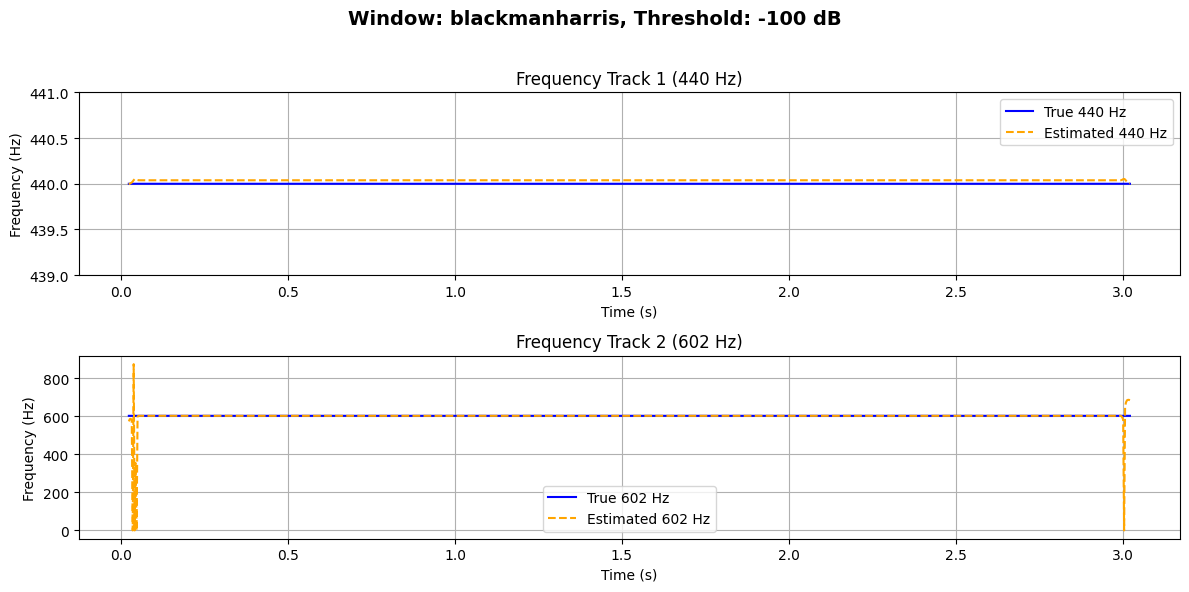

In [20]:
# Parameters
M = 2047
N = 4096
H = 128
input_file = '../sounds/sines-440-602-hRange.wav'

windows = ['blackman', 'blackmanharris']
thresholds = [-60, -80, -100]

# Loop through each window type and threshold
for window in windows:
    for t in thresholds:
        # Run frequency tracker error
        meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)
        print(f"Window: {window}, Threshold: {t} dB → Mean frequency estimation error: {meanErr}")

        # --- Plot true vs estimated frequency tracks ---
        plt.figure(figsize=(12, 6))
        plt.suptitle(f"Window: {window}, Threshold: {t} dB", fontsize=14, fontweight='bold')

        # 440 Hz component
        plt.subplot(2, 1, 1)
        plt.plot(tStamps, fTrackTrue[:, 0], label='True 440 Hz', color='blue')
        plt.plot(tStamps, fTrackEst[:, 0], '--', label='Estimated 440 Hz', color='orange')
        plt.title('Frequency Track 1 (440 Hz)')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.ylim(439, 441)
        plt.legend()
        plt.grid(True)

        # 602 Hz component
        plt.subplot(2, 1, 2)
        plt.plot(tStamps, fTrackTrue[:, 1], label='True 602 Hz', color='blue')
        plt.plot(tStamps, fTrackEst[:, 1], '--', label='Estimated 602 Hz', color='orange')
        plt.title('Frequency Track 2 (602 Hz)')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


**Question  E5 - 3.2:**

#### Explain the results of 3.1
------

To select the most appropriate window for the sinusoidal analysis, we first compare the **relative amplitudes** of the two sinusoids in the input signal (seen also in Sonic VIsualizer):

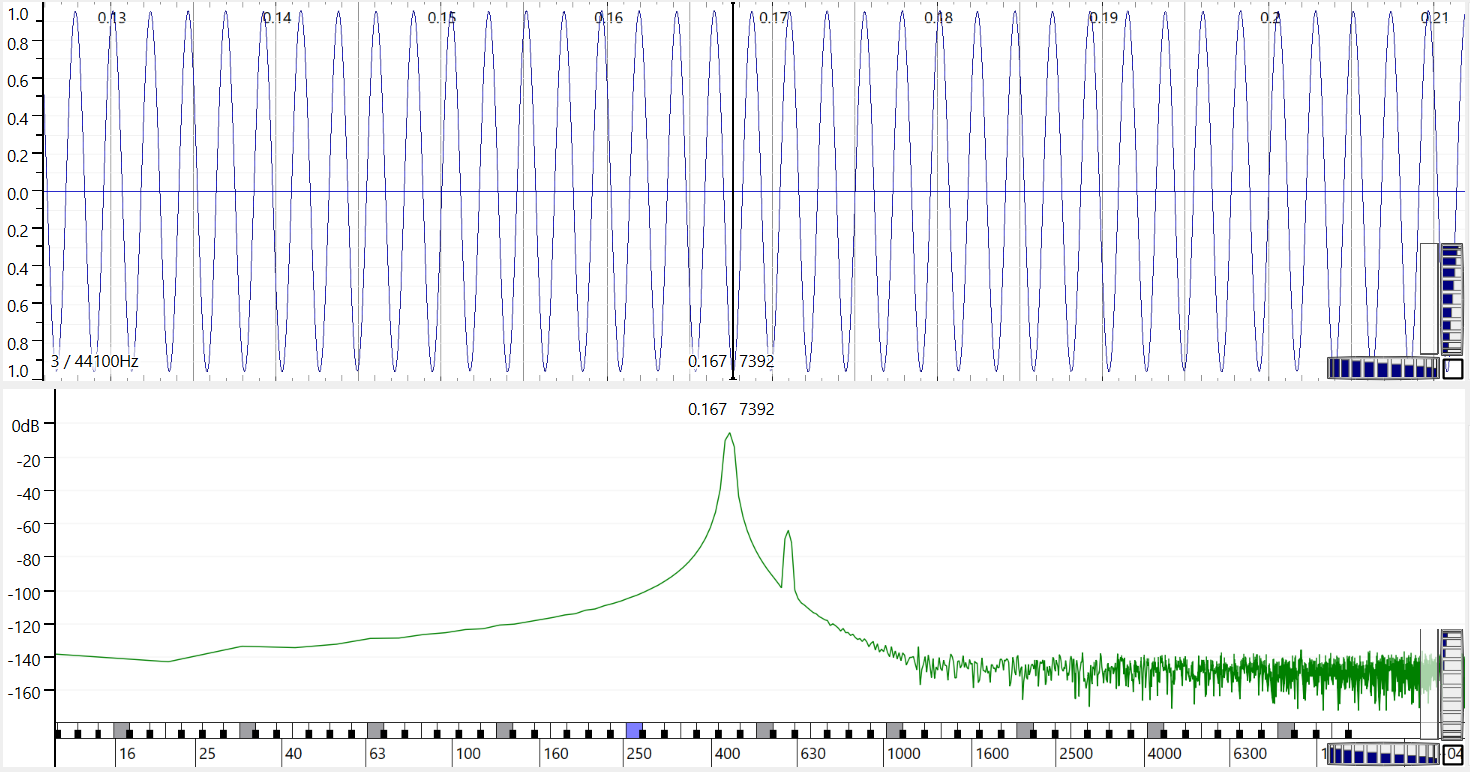

$$
s(t) = \sin(2\pi \cdot 440t) + 2 \times 10^{-3} \sin(2\pi \cdot 602t)
$$

The amplitude of the strong component (440 Hz) is $A_1 = 1.0$, and the weak component (602 Hz) is $A_2 = 2\times10^{-3}$.  
We express their amplitudes in decibels using:

$$
A_{\text{dB}} = 20 \log_{10}(A)
$$

Hence:

| Component | Linear Amplitude | Level (dB) |
|------------|------------------|-------------|
| 440 Hz (strong) | 1.0 | 0 dB |
| 602 Hz (weak) | 0.002 | −53.98 dB |

The 602 Hz component is therefore approximately **54 dB weaker** than the 440 Hz component.



When performing spectral analysis, the **window type** determines the amount of **spectral leakage**, characterized by its *peak sidelobe level* (in dB).  
To correctly detect the weak component, the sidelobes of the strong tone must be **below** the level of the weaker tone (≈ −54 dB).

| Window | Peak Sidelobe (dB) | Safe? |
|:--|:--:|:--:|
| Boxcar | −13 dB | ✗ |
| Hann | −31 dB | ✗ |
| Hamming | −41 dB | ✗ |
| **Blackman** | −58 dB | ✓ |
| **Blackman-Harris (4-term)** | −92 dB | ✓✓ |


- Windows with sidelobe levels above −54 dB (Boxcar, Hann, Hamming) will **mask** the 602 Hz component with the sidelobes of the 440 Hz tone.  
- The **Blackman window** (−58 dB) just meets the requirement and can work acceptably.  
- The **Blackman-Harris window** (≈ −92 dB) provides the **largest safety margin** (≈ 38 dB lower than the weak tone).

The recommended windows would be `'blackmanharris'` (safest) or `'blackman'` (borderline).

For the threshold:
- $t = -80~\text{dB}$ : conservative, allows detection of the −54 dB component and rejects weaker noise.
- $t = -60~\text{dB}$ : borderline, may include sidelobes if the window has higher leakage.
- $t = -100~\text{dB}$ : permissive, can include noise.

The following table summarizes the mean frequency estimation errors for each configuration:

$$
\begin{array}{|c|c|c|c|}
\hline
\textbf{Window} & \textbf{Threshold (dB)} & \textbf{Mean Error (440 Hz) [Hz]} & \textbf{Mean Error (602 Hz) [Hz]} \\
\hline
\text{Blackman} & -60 & 0.08 & 362.61 \\
\text{Blackman} & -80 & 0.08 & 2.38 \\
\text{Blackman} & -100 & 0.08 & 2.38 \\
\text{Blackman--Harris} & -60 & 0.04 & 602.00 \\
\text{Blackman--Harris} & -80 & 0.04 & \mathbf{0.06} \\
\text{Blackman--Harris} & -100 & 0.04 & \mathbf{0.06} \\
\hline
\end{array}
$$

From the results, it is evident that both the **window type** and the **magnitude threshold** significantly influence the ability to detect and accurately track the weaker sinusoidal component at 602 Hz.

At higher thresholds ($t = -60$ dB), the weaker component lies below the detection level, resulting in large estimation errors.  
When the threshold is reduced ($t \leq -80$ dB), the 602 Hz component becomes detectable and the frequency tracking error drops below 2 Hz.

The **Blackman–Harris window** provides the most accurate results, with sub-hertz mean errors for both tones.  
This is explained by its **side-lobe attenuation of approximately −92 dB**, which effectively minimizes spectral leakage from the strong 440 Hz sinusoid, preventing it from masking the weaker 602 Hz component.  
In contrast, the **Blackman window** (side-lobe level ≈ −58 dB) allows greater leakage, requiring a stricter detection threshold to achieve acceptable performance.




## Part 4 - Sinusoidal modeling of a multicomponent signal

In this part you will perform a sinusoidal analysis of a complex synthetic signal, using `sineModelAnal()` exploring the different parameters of the model. Use the sound `multiSines.wav` and explain the difficulties encoutered and solutions found.

This is an open question without a single specific answer. We will use the sound `multiSines.wav`, which is a synthetic audio signal with sharp attacks, close frequency components with a wide range of amplitudes, and time varying chirps with frequency tracks that cross over. All these characteristics make this signal difficult to analyze with `sineModelAnal()`. Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or Sonic Visualizer to see its spectrogram.

We have written a basic code for sinusoidal analysis, you are free to modify it. You should be able to generate a sound that is perceptually undistinguishable from the input sound.


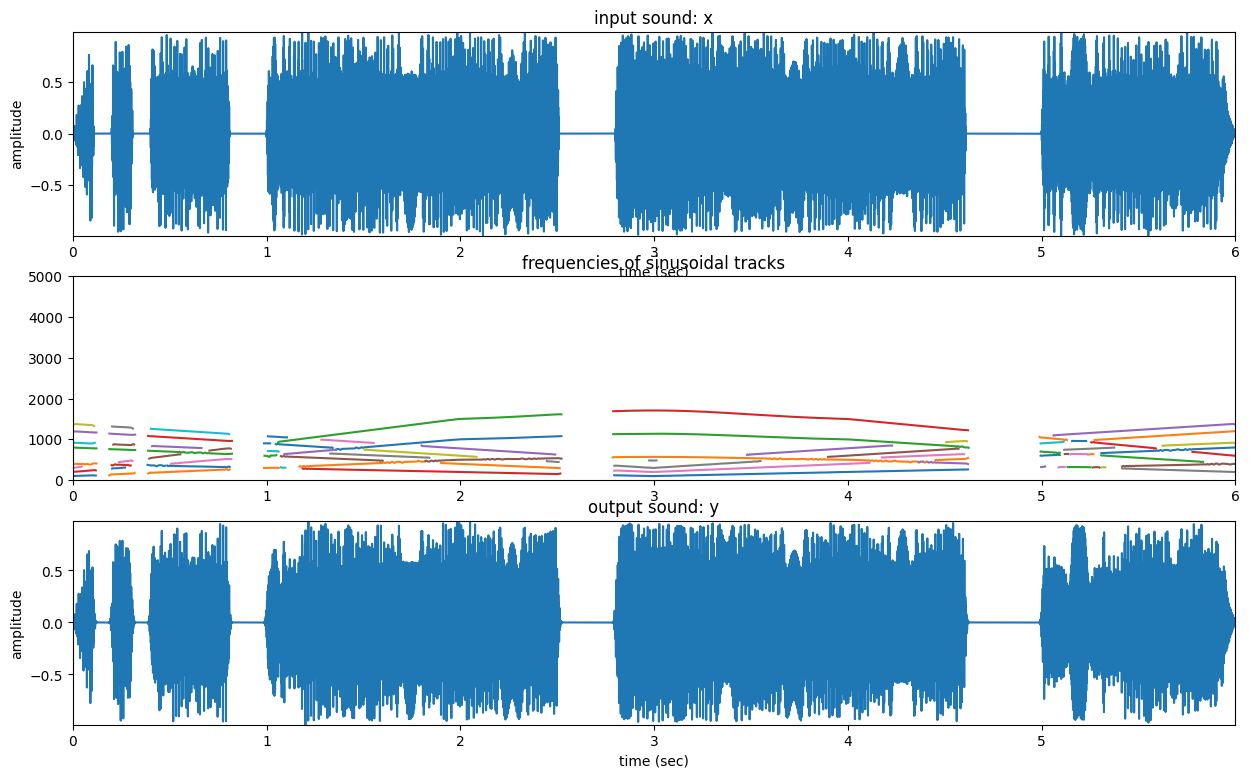

In [14]:
# E5 - 4.1: 
# Set the analysis parameters of sineModelAnal() to perform the best analysis of multiSines.wav

import IPython.display as ipd

input_file = '../sounds/multiSines.wav'

### set the analysis parameters

window = 'blackmanharris'
M = 2047
N = 2048
t = -70
minSineDur = 0.02
maxnSines = 80
freqDevOffset = 10
freqDevSlope = 0.001


# no need to modify the code after here
Ns = 512                                      # size of fft used in synthesis
H = 128                                       # hop size (has to be 1/4 of Ns)

fs, x = UF.wavread(input_file)                # read input sound
w = get_window(window, M)                     # compute analysis window

# analyze the sound with the sinusoidal model
tfreq, tmag, tphase = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)

# synthesize the output sound from the sinusoidal representation
y = SM.sineModelSynth(tfreq, tmag, tphase, Ns, H, fs)

# create figure to show plots
plt.figure(figsize=(15, 9))

# frequency range to plot
maxplotfreq = 5000.0

# plot the input sound
plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot the sinusoidal frequencies
plt.subplot(3,1,2)
if (tfreq.shape[1] > 0):
    numFrames = tfreq.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    tfreq[tfreq<=0] = np.nan
    plt.plot(frmTime, tfreq)
    plt.axis([0, x.size/float(fs), 0, maxplotfreq])
    plt.title('frequencies of sinusoidal tracks')

# plot the output sound
plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y)
plt.axis([0, y.size/float(fs), min(y), max(y)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('output sound: y')

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

**Question  E5 - 4.2:**

#### Explain the results of Part 4
------

The signal in **multiSines.wav** is challenging for sinusoidal modelling.  
From inspecting both the **waveform** and the **spectrogram**, we observe in Sonic Visualiser:

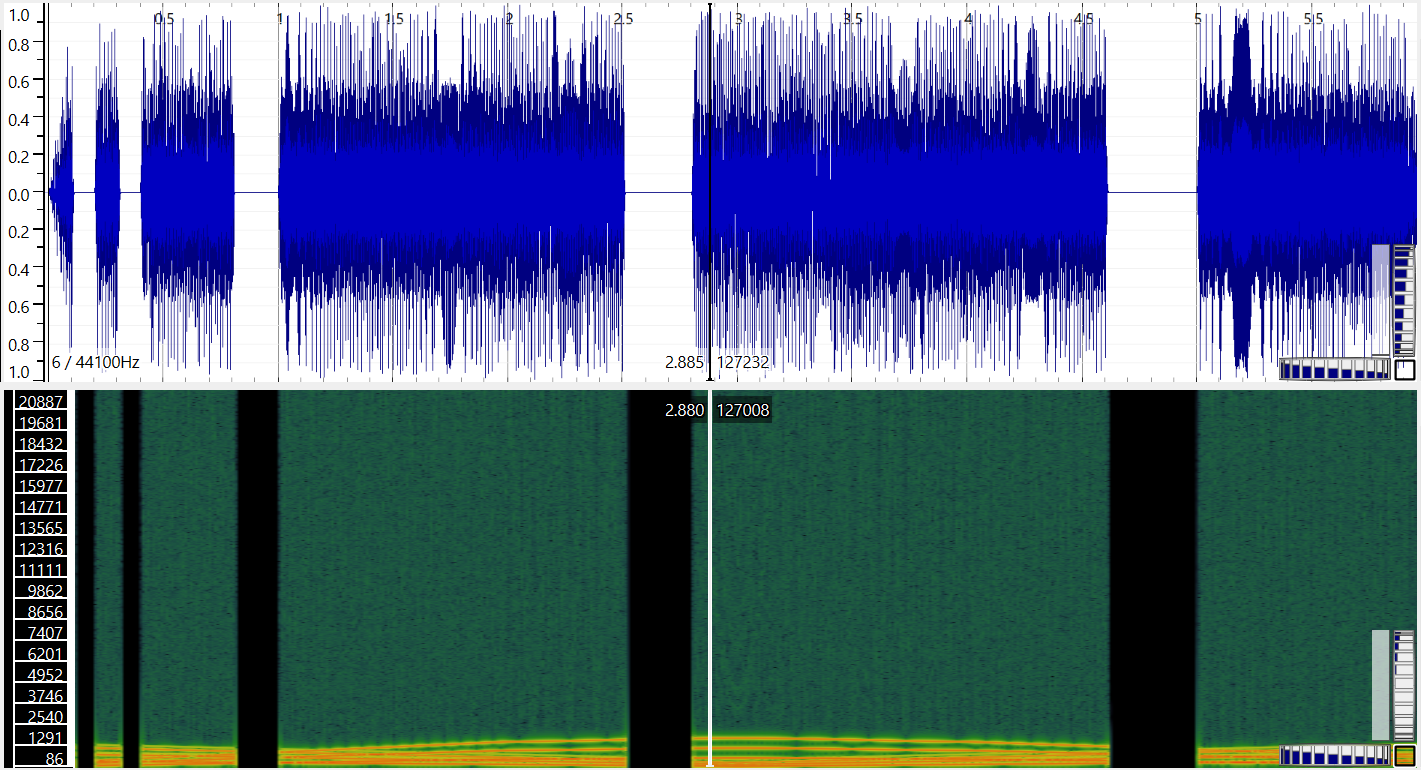


- **Sharp attacks**, which require good time resolution.
- **Closely spaced sinusoids**, requiring high frequency resolution.
- **Large amplitude differences**, where weak sinusoids may be masked by strong ones.
- **Time-varying chirps with crossing tracks**, which are difficult for the tracking algorithm to follow continuously.

These characteristics make a simple parameter choice insufficient: we must balance **time resolution**, **frequency resolution**, and **tracking stability**.

For this analysis, the recommended window is **Blackman–Harris window** that provides:

- **Very low sidelobes**, which reduce spectral leakage from loud components into neighboring frequencies.  
- Better preservation of **low-amplitude sinusoids**, which otherwise disappear under the sidelobes of stronger ones.  
- A clean spectral main lobe that improves peak detection and frequency estimation.

This makes it particularly suitable for **multi-component** signals with large **amplitude differences**.

Just out of curiosity, I compared five windows (*boxcar, hann, hamming, blackman, blackmanharris*) with the same parameters (M = 2047
N = 4096
t = -80
minSineDur = 0.01
maxnSines = 100
freqDevOffset = 30
freqDevSlope = 0.002) and the plots show:

- **boxcar**

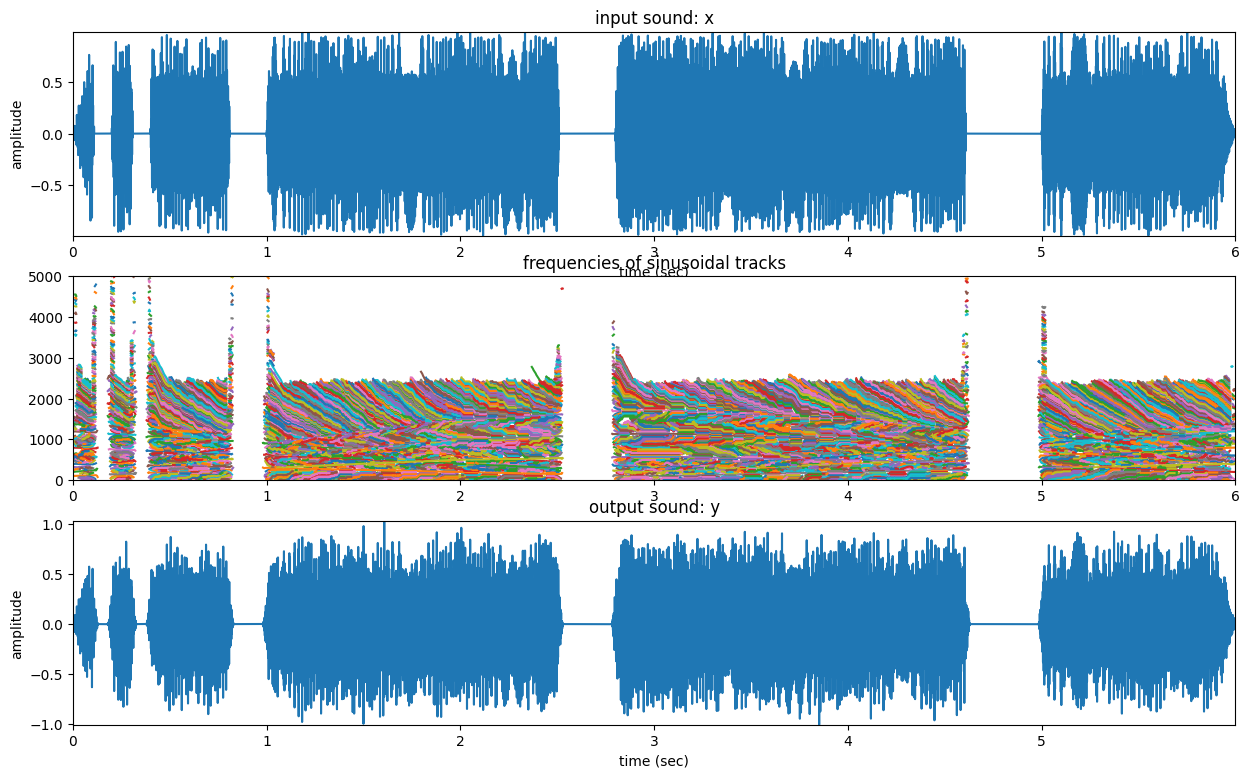

- **hann**

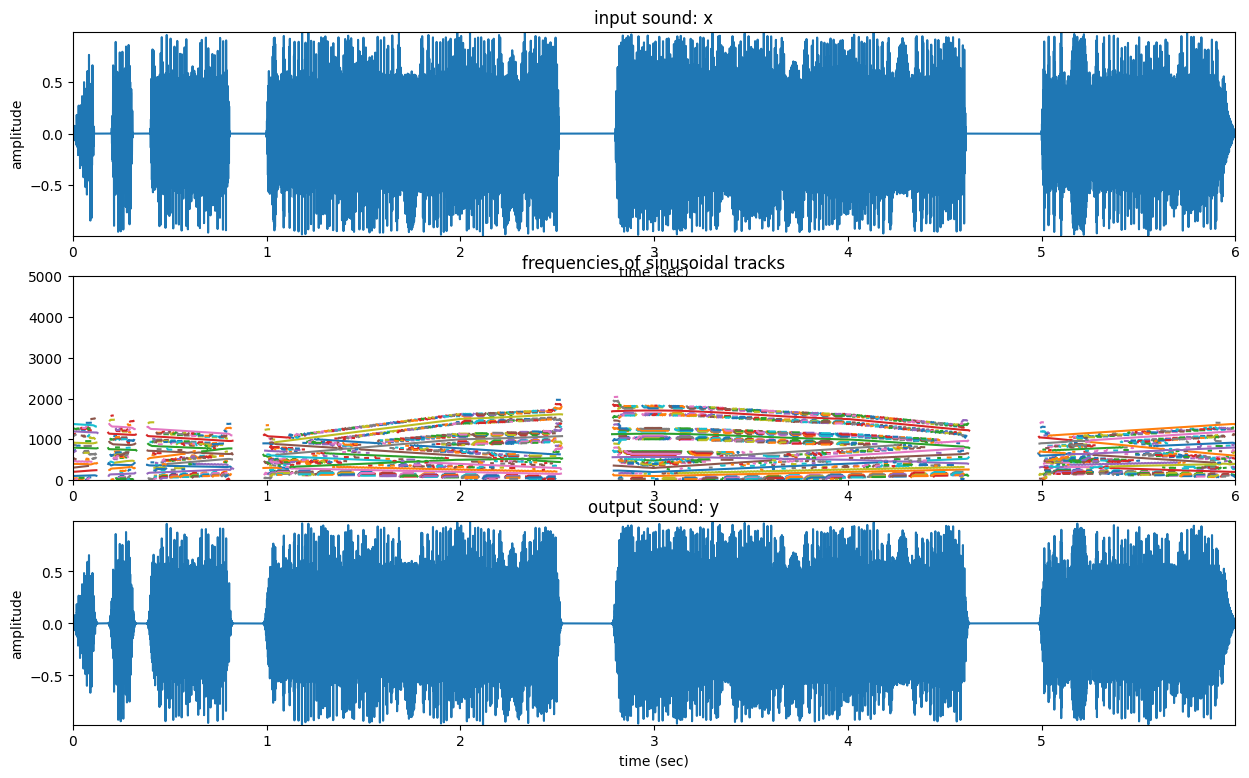

- **hamming**

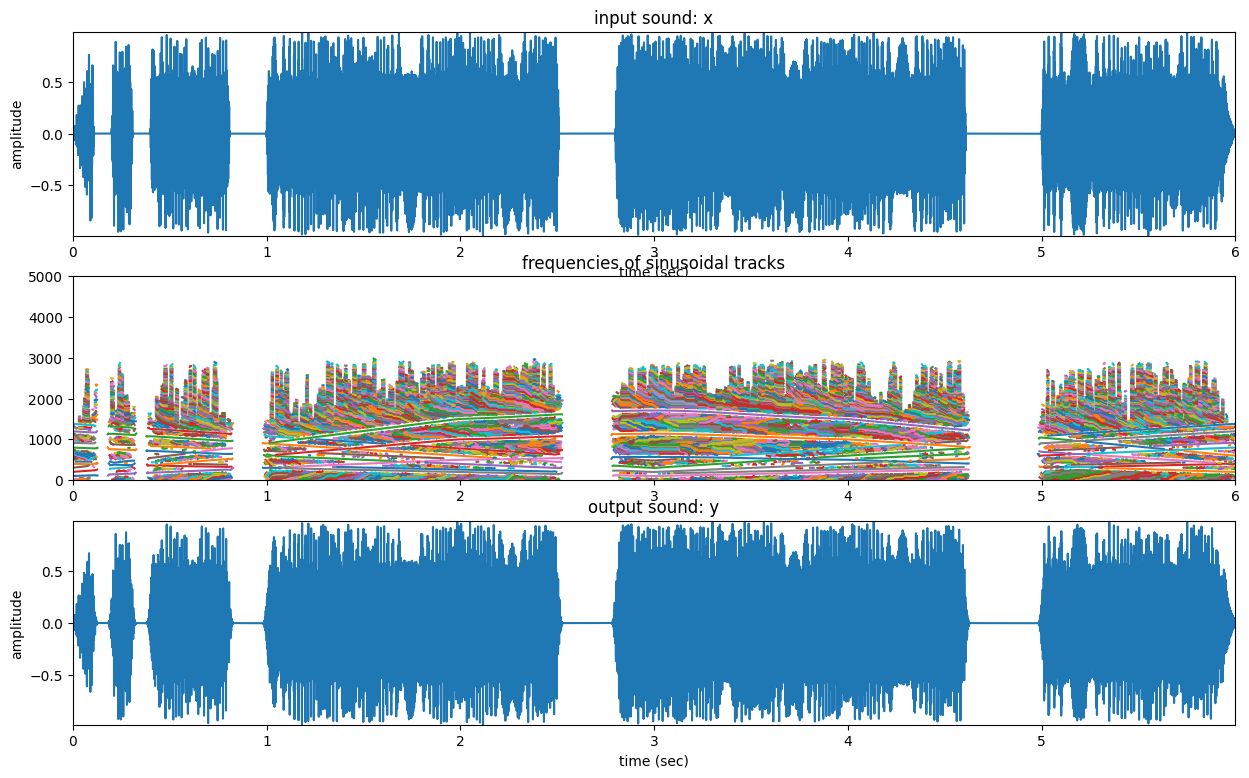

- **blackman**

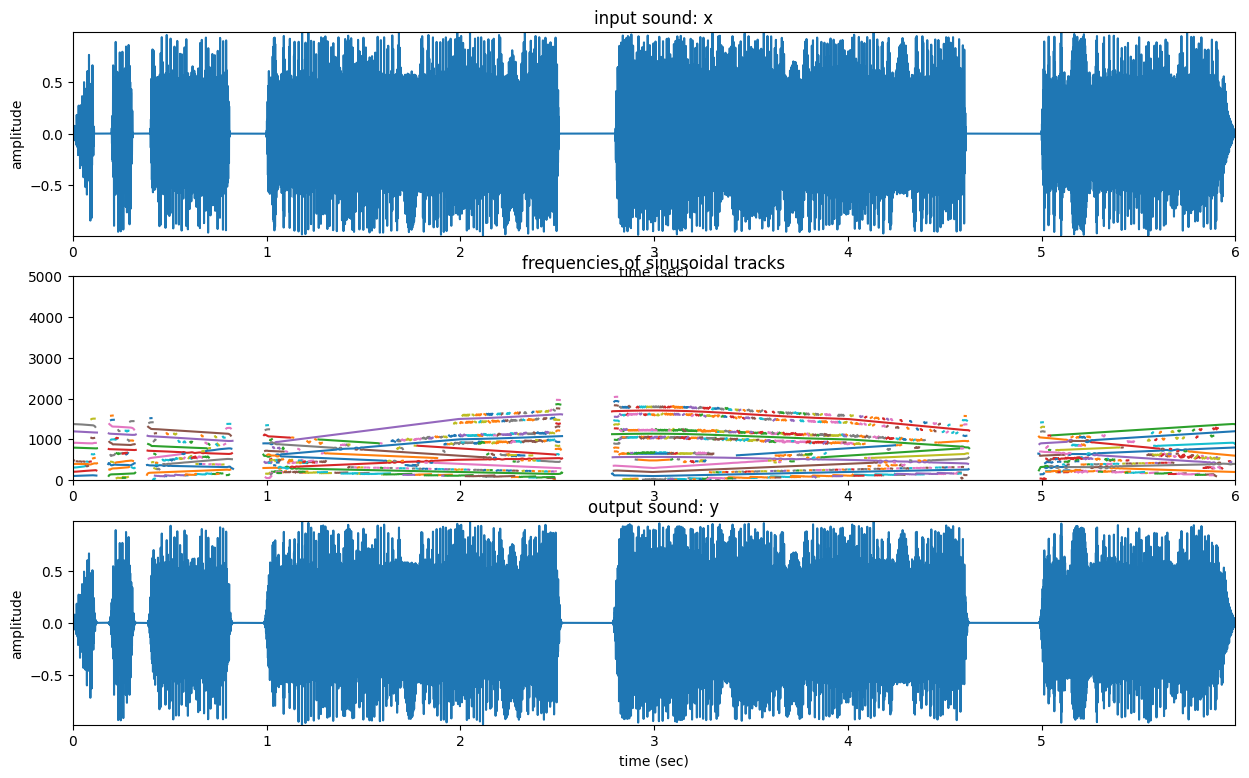

- **blackmanharris**

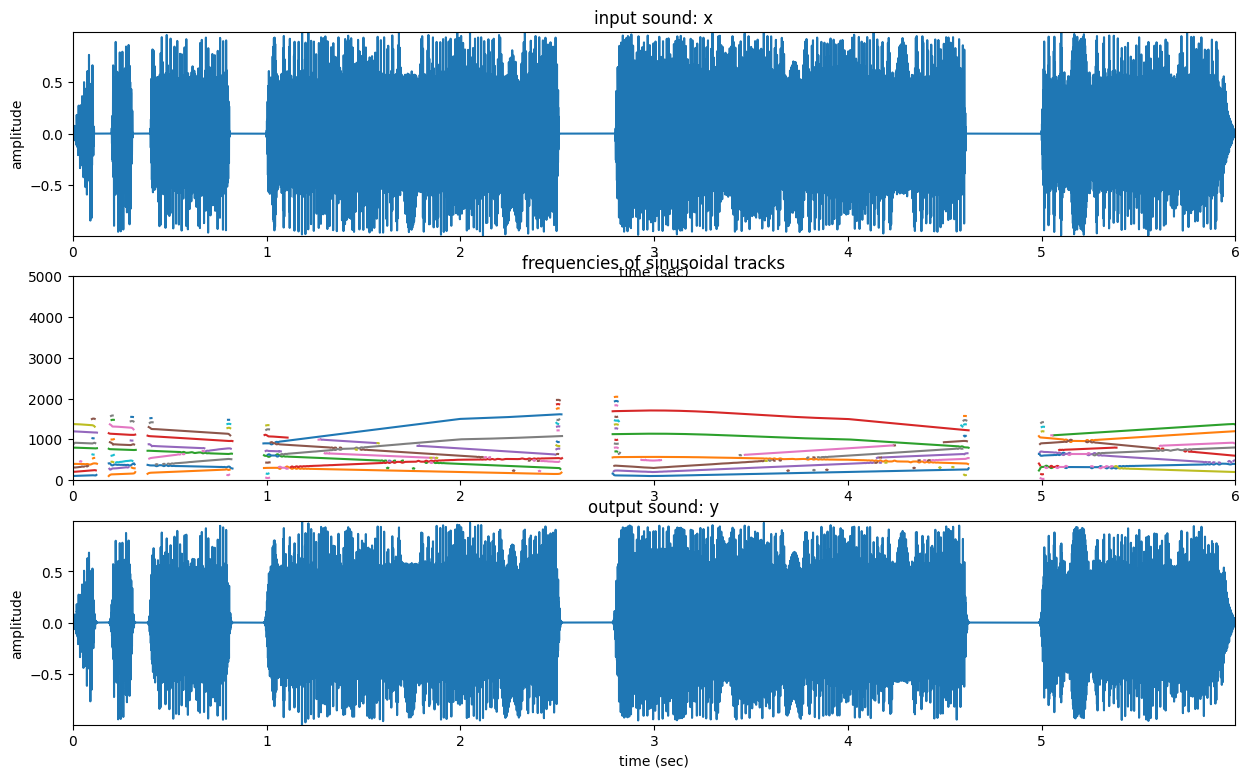


These results confirm my choice of *blackmanharris* window. In fact, perceptually, the reconstruction is still very good, because the sinusoidal model is so robust that even if the frequency tracks are imperfect, the synthesis still reconstructs the main sinusoidal energy.

But the sinusoidal tracks look messy. In the middle plot of every window except *blackmanharris* we encounter:

- Very dense frequency trajectories

- Lots of overlapping components

- Tracks that are noisier and less stable

- Some visible frequency "jitter" and random jumps

These are the reasons why we choose *blackmanharris* window for this experiment.


For the other parameters, we have to keep in mind these challenges:

1. **Sharp attacks**  
   Sudden changes in amplitude require a smaller window size $ M $, but this reduces frequency resolution.

2. **Close frequency components**  
   To avoid merging of components, a larger window is needed:  
   $$
   \Delta f = \frac{f_s}{M}.
   $$

3. **Amplitude variability**  
   If the detection threshold is too high, low-amplitude sinusoids are lost; if too low, noise peaks are detected.

4. **Crossing sinusoidal tracks**  
   Time-varying chirps require flexible tracking; otherwise trajectories may be swapped or broken.


A balanced and effective configuration that I tried is:

- **Window size:**  
  $$
  M \approx 2047
  $$
  to compromise between time and frequency resolution.

- **Peak detection threshold:**  
  $$
  t = -80\ \text{dB}.
  $$

- **Tracking parameters:**  
  $$
  \text{freqDevOffset} \approx 30\ \text{Hz}, \qquad
  \text{freqDevSlope} \approx 0.002.
  $$

- **Minimum sine duration:**  
  $$
  \text{minSineDur} = 0.01\ \text{s}.
  $$

- **Maximum number of sinusoids:**  
  A value such as 100–150 to avoid losing components.


## Parameter Configurations for `sineModelAnal()` with Blackman–Harris Window

Below are five configurations used to compare the behaviour of the sinusoidal model on **multiSines.wav**:
---

**Configuration A — Balanced**  
Good compromise between time and frequency resolution.

$$ \text{window} = \text{'blackmanharris'} $$
$$ M = 2047,\quad N = 2048,\quad t = -80 $$
$$ \text{minSineDur} = 0.01,\quad \text{maxnSines} = 120 $$
$$ \text{freqDevOffset} = 30,\quad \text{freqDevSlope} = 0.002 $$

Plot:

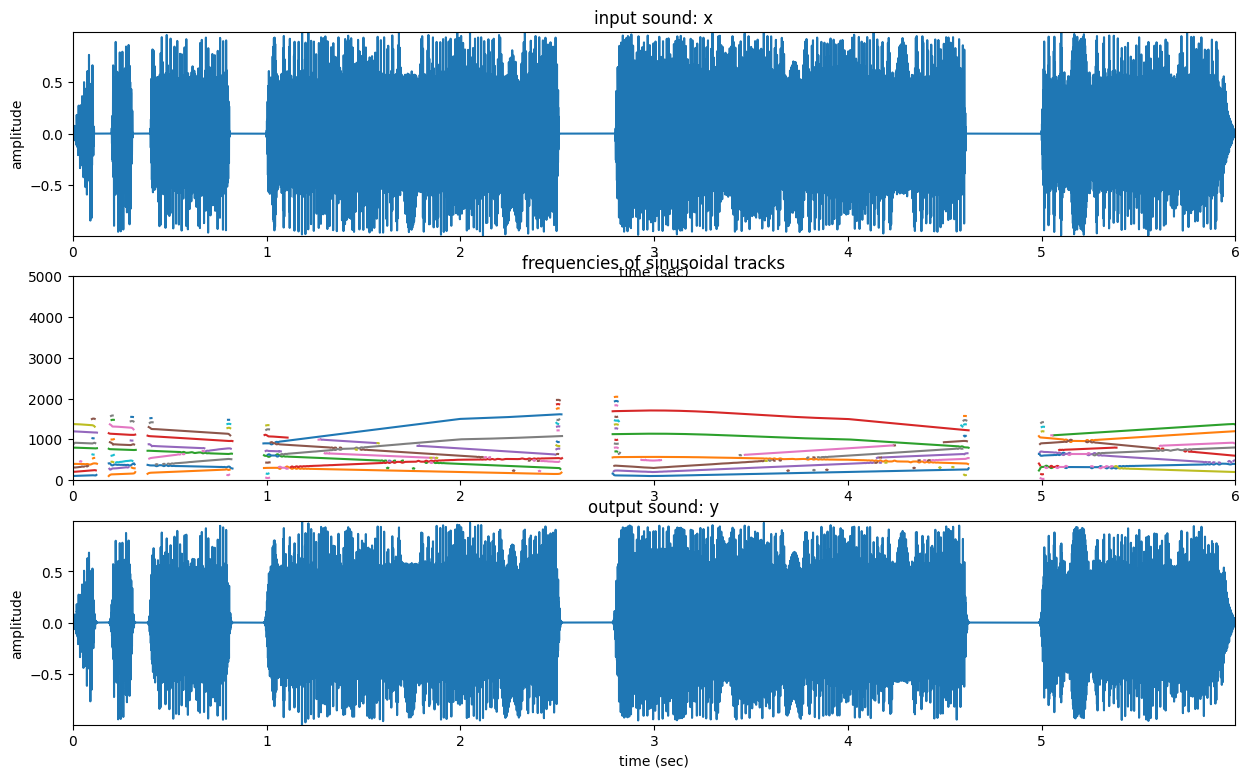


---

**Configuration B — High Frequency Resolution**  
Large window → better separation of close partials.

$$ \text{window} = \text{'blackmanharris'} $$
$$ M = 4095,\quad N = 4096,\quad t = -85 $$
$$ \text{minSineDur} = 0.015,\quad \text{maxnSines} = 150 $$
$$ \text{freqDevOffset} = 35,\quad \text{freqDevSlope} = 0.002 $$

Plot:

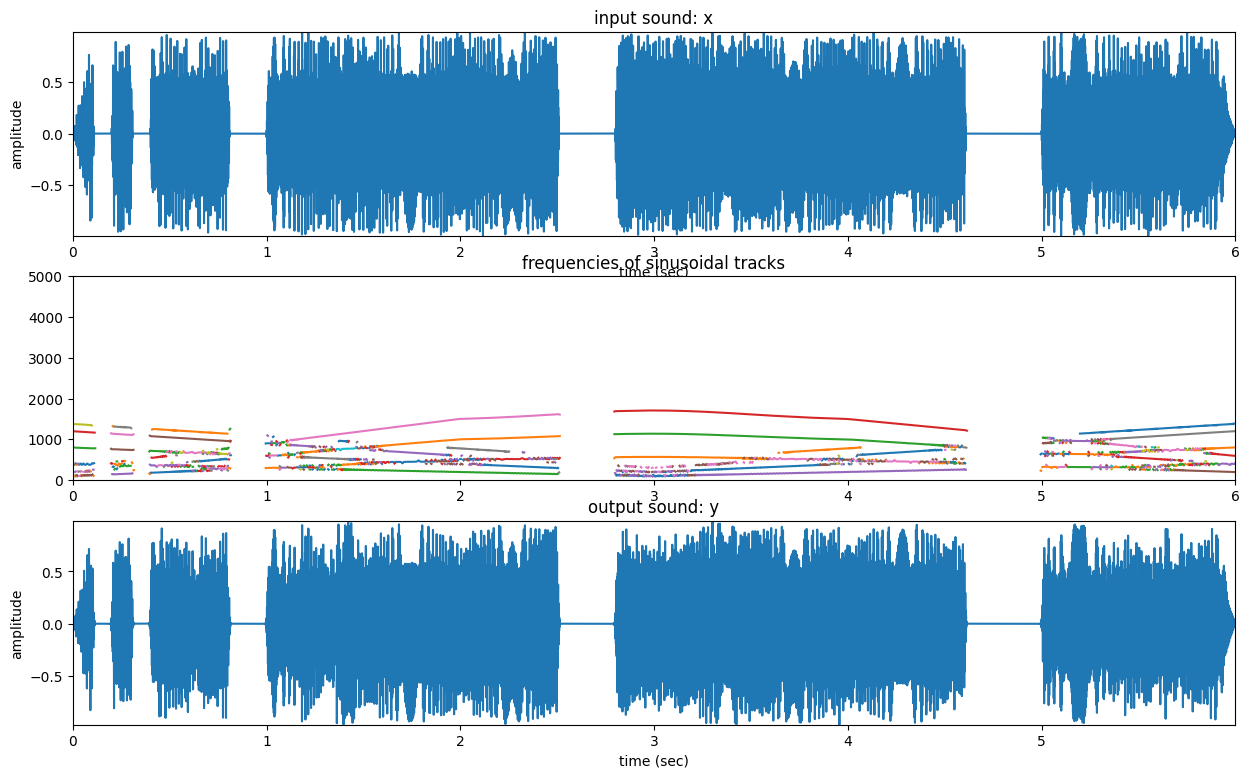


---

**Configuration C — High Time Resolution**  
Smaller window → better transient tracking.

$$ \text{window} = \text{'blackmanharris'} $$
$$ M = 1023,\quad N = 1024,\quad t = -75 $$
$$ \text{minSineDur} = 0.005,\quad \text{maxnSines} = 100 $$
$$ \text{freqDevOffset} = 20,\quad \text{freqDevSlope} = 0.001 $$

Plot:

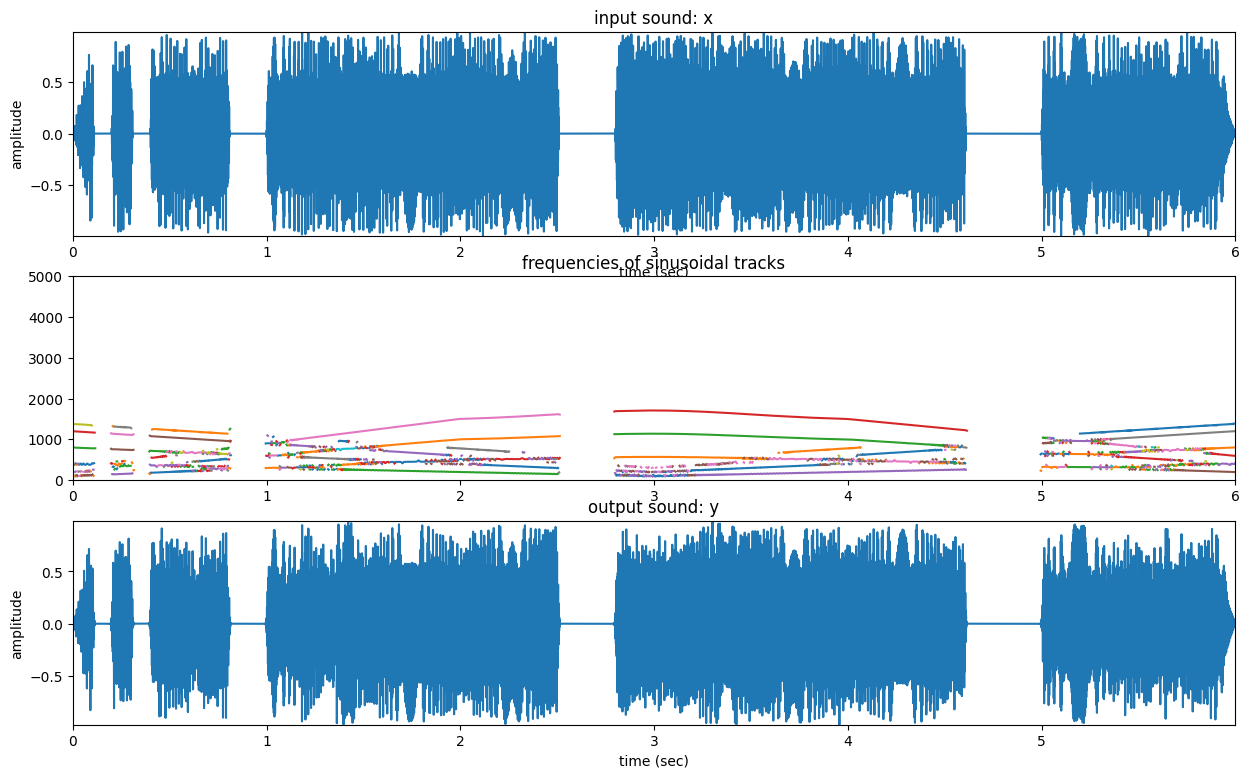



---

**Configuration D — Permissive Tracking**  
Allows large deviations; useful for chirps and crossing tracks.

$$ \text{window} = \text{'blackmanharris'} $$
$$ M = 2047,\quad N = 2048,\quad t = -90 $$
$$ \text{minSineDur} = 0.0,\quad \text{maxnSines} = 150 $$
$$ \text{freqDevOffset} = 50,\quad \text{freqDevSlope} = 0.004 $$

Plot:

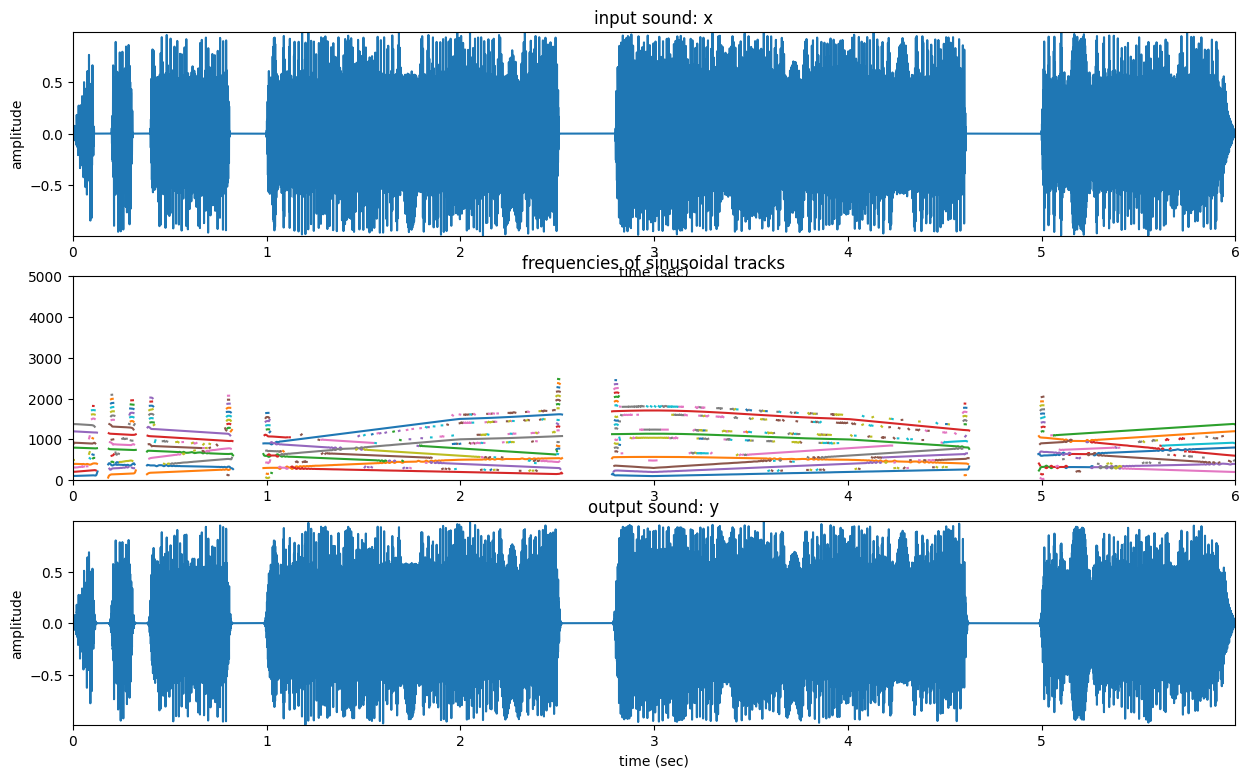


---

**Configuration E — Strict Tracking**  
Conservative matching → fewer spurious tracks.

$$ \text{window} = \text{'blackmanharris'} $$
$$ M = 2047,\quad N = 2048,\quad t = -70 $$
$$ \text{minSineDur} = 0.02,\quad \text{maxnSines} = 80 $$
$$ \text{freqDevOffset} = 10,\quad \text{freqDevSlope} = 0.001 $$

Plot:

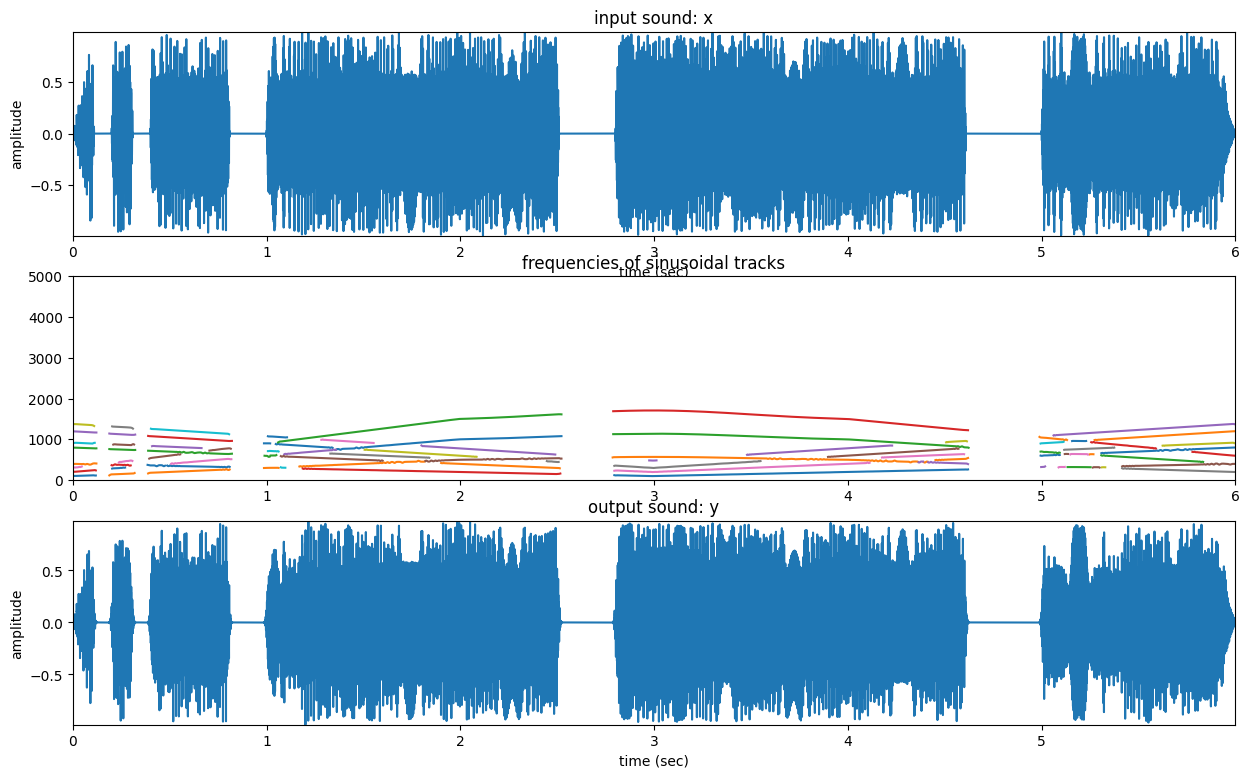

---

## Comparison of Configurations A–E

Below is a brief qualitative comparison of the five tested configurations for the sinusoidal analysis of *multiSines.wav*:

### Summary Table

| Config | Track Density | HF Content | Smoothness | Spurious Peaks | Output Quality | Notes |
|--------|---------------|------------|------------|----------------|----------------|-------|
| **A** | Medium | Low | Poor | Many | Poor | Noisy tracking, unstable. |
| **B** | Very High | Excellent | Medium | Some | Very Good | Most detailed, slightly messy. |
| **C** | Medium | Weak | Good | Few | Good | Balanced but loses detail. |
| **D** | High | Very Good | Good | Moderate | **Best** | Best trade-off of detail vs stability. |
| **E** | Very Low | Poor | Excellent | None | Fair | Too sparse; underfits the signal. |

### Brief Comparison

- **A** fails due to many spurious short-lived tracks and low spectral detail.  
- **B** captures the richest structure but introduces clutter from excessive peak tracking.  
- **C** is cleaner but removes too many harmonics, sounding slightly dull.  
- **D** achieves the best balance: detailed, stable tracks and high-quality reconstruction.  
- **E** is overly conservative, tracking too few sinusoids and losing important components.

**Overall best configuration: D.**

